In [1]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'

%matplotlib inline

import csv
import re
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from csv_reader import read_csv
from aux import set_smallest_n_zero
from copy import deepcopy as copy

plt.rcParams['font.size'] = 15
plt.rcParams['axes.linewidth'] = 3.0

warnings.filterwarnings('ignore')

rule_names = [ # Define labels for all rules to be run during simulations
    r'',
    r'$y$',
    r'$x$',
    r'$y^2$',
    # r'$x^2$',
    r'$x \, y$',
    r'$x \, y^2$',
    r'$x^2 \, y$',
    # r'$x^2 \, y^2$',
    # r'$y_{int}$',
    # r'$x \, y_{int}$',
    # r'$x_{int}$',
    r'$x_{int} \, y$',
    r'$x_{int} \, y^2$',

    r'$w$',
    r'$w \, y$',
    r'$w \, x$',
    r'$w \, y^2$',
    # r'$w \, x^2$',
    r'$w \, x \, y$',
    r'$w \, x \, y^2$',
    r'$w \, x^2 \, y$',
    # r'$w \, x^2 \, y^2$',
    # r'$w y_{int}$',
    # r'$w x \, y_{int}$',
    # r'$w x_{int}$',
    r'$w x_{int} \, y$',
    r'$w x_{int} \, y^2$',

    # r'$w^2$',
    # r'$w^2 \, y$',
    # r'$w^2 \, x$',
    # r'$w^2 \, y^2$',
    # r'$w^2 \, x^2$',
    # r'$w^2 \, x \, y$',
    # r'$w^2 \, x \, y^2$',
    # r'$w^2 \, x^2 \, y$',
    # r'$w^2 \, x^2 \, y^2$',
    # r'$w^2 y_{int}$',
    # r'$w^2 x \, y_{int}$',
    # r'$w^2 x_{int}$',
    # r'$w^2 x_{int} \, y$',
]

general_rule_names = copy(rule_names)

rule_names = [
    [r'$E \rightarrow E$ ' + r_name for r_name in rule_names],
    [r'$E \rightarrow I$ ' + r_name for r_name in rule_names],
    [r'$I \rightarrow E$ ' + r_name for r_name in rule_names],
]
rule_names = np.array(rule_names).flatten()

In [2]:
def format_single_axs(axs):
    axs.spines['right'].set_visible(False)
    axs.spines['top'].set_visible(False)

def format_axs(axs):
    if type(axs) is list or type(axs) is np.ndarray:
        for i in range(len(axs)):
            format_single_axs(axs[i])
    else:
        format_single_axs(axs)

def calc_entropy(l):
    abs_l = np.abs(l)
    per_l = abs_l / np.sum(abs_l)
    return -np.dot(np.log(per_l), per_l)

def plot_all(file_name, start=0, yscale=None, n_categories=1, loss_yscale=None):
    # load file with losses
    file_path = f'./sims_out/{file_name}/outcmaes/fit.dat'
    df_loss = read_csv(file_path)
    
    # Plot best loss for epoch and best loss ever
    scale = 2
    fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 2.5 * scale))

    x = np.arange(df_loss.shape[0])
    
    axs.plot(x[start:], df_loss['best'][start:])
    axs.plot(x[start:], df_loss['bestever'][start:])
    if loss_yscale is not None:
        axs.set_ylim(0, loss_yscale)
    else:
        axs.set_ylim(0)
    axs.set_xlabel('Epochs')
    axs.set_ylabel('Loss')
    axs.set_title(file_name)
    
    # load file with best params for epoch
    coef_start = 5
    file_path = f'./sims_out/{file_name}/outcmaes/xmean.dat'
    df_params = read_csv(file_path, read_header=False)

    # plot entropy of param dist against epochs
    scale = 2
    fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 2.5 * scale))
    axs.set_xlabel('Epochs')
    axs.set_ylabel('Entropy')
    
    entropy = np.array([calc_entropy(df_params.iloc[i][coef_start:]) for i in x])
    min_entropy_idx = np.argmin(entropy)
    min_entropy_loss = np.array(df_loss['best'])[min_entropy_idx]
    print(file_name)
    print(f'Min entropy idx: {min_entropy_idx}')
    print(f'Loss: {min_entropy_loss}')
    print(f'{np.array(df_params.iloc[min_entropy_idx][coef_start:])}')
    print(f'Entropy: {entropy[min_entropy_idx]}\n')
    
    axs.plot(x, entropy, c='green')
    
    # plot all coefficients
    scale = 2
    fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 2.5 * scale))
    axs.set_xlabel('Epochs')
    axs.set_ylabel('Coefficient')
    if yscale is not None:
        axs.set_ylim(-yscale, yscale)
    
    x = np.arange(df_params.shape[0])[start:]
    for i in range(coef_start, df_params.shape[1]):
        axs.plot(x, df_params[df_params.columns[i]][start:])
        
    # plot the coefficients assigned to each plasticity rule (unsorted by size)
    scale = 2
    fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 2.5 * scale))
    min_loss_idx = np.argmin(np.array(df_loss['best']))
    plasticity_coefs = np.array(df_params.iloc[min_loss_idx][coef_start:])
    partial_rules_len = int(len(plasticity_coefs) / n_categories)
    for l in range(n_categories):
        axs.bar(np.arange(partial_rules_len) + l * partial_rules_len, plasticity_coefs[l * partial_rules_len: (l+1) * partial_rules_len])
    axs.set_xticks(np.arange(len(plasticity_coefs)))
    axs.set_xticklabels(rule_names, rotation=60, ha='right')
    axs.set_xlim(-1, len(plasticity_coefs))
    if yscale is not None:
        axs.set_ylim(-yscale, yscale)
        
def find_desc_indices(x, losses):
    min_loss = losses[0]
    x_mins = [0]
    
    for i, x_i in enumerate(x):
        if losses[i] < min_loss:
            x_mins.append(x_i)
            min_loss = losses[i]
    return np.array(x_mins)
      
def plot_all_2(file_name, n_plasticity_coefs, batch_size, start=0, yscale=None, n_categories=1, loss_yscale=None):
    train_data_path = f'./sims_out/{file_name}/train_data.csv'
    test_data_path = f'./sims_out/{file_name}/test_data.csv'
    
    df_train = read_csv(train_data_path, read_header=False)
    df_test = read_csv(test_data_path, read_header=False)
    
    # plot synaptic effects per rule
    scale = 2
    fig, axs = plt.subplots(1, 2, figsize=(6 * scale, 2.5 * scale))
    format_axs(axs)
    
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Synaptic effect')
    if yscale is not None:
        axs[0].set_ylim(0, yscale)
    
    syn_effect_start = 2 + batch_size + n_plasticity_coefs
    syn_effect_end = 2 + batch_size + n_plasticity_coefs + n_plasticity_coefs
    x = np.arange(df_train.shape[0])[start:]
    losses = df_train[df_train.columns[1]][start:]
    x_mins = []

    for i in range(0, len(x), 15):
        x_mins.append(np.argmin(losses[i:i+15]) + i)
        
    x_mins = np.array(x_mins)
    x_best_min = np.argmin(losses)
    
    x_test = df_test[df_test.columns[0]]
    losses_test = df_test[df_test.columns[1]]
    
    final_syn_effects = []
    final_coefs = []
    
    for i in range(syn_effect_start, syn_effect_end):
#         axs[0].plot(df_train[df_train.columns[0]][start:][x_mins], df_train[df_train.columns[i]][start:][x_mins])
        
        final_syn_effects.append(df_train[df_train.columns[i]][start:][x_best_min])
        
    final_syn_effects = np.array(final_syn_effects)
        
    axs[1].plot(x_mins[1:], losses[x_mins[1:]], color='black')
#     axs[1].plot(x_test, losses_test, color='blue')
    axs[1].set_ylim(0, 200)
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epochs')
        
    plasticity_coefs_start = 2 + batch_size
    plasticity_coefs_end = 2 + batch_size + n_plasticity_coefs
    
    for i in range(plasticity_coefs_start, plasticity_coefs_end):
        axs[0].plot(df_train[df_train.columns[0]][start:][x_mins], df_train[df_train.columns[i]][start:][x_mins])
        final_coefs.append(df_train[df_train.columns[i]][start:][x_best_min])
        
    fig.tight_layout()
    
    # plot the synaptic effects of each plasticity rule (unsorted by size)
    scale = 2
    fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 2.5 * scale))
    format_axs(axs)
    
    partial_rules_len = int(len(final_syn_effects) / n_categories)

    for l in range(n_categories):
        x = np.arange(partial_rules_len) + l * partial_rules_len
        y = final_syn_effects[l * partial_rules_len: (l+1) * partial_rules_len]
#         y_err = final_syn_effect_stds[l * partial_rules_len: (l+1) * partial_rules_len]
        axs.bar(x, y, alpha=0.3)
#         axs.errorbar(x, y, yerr=y_err, ls='none')

    axs.set_xticks(np.arange(len(final_syn_effects)))
    axs.set_xticklabels(rule_names[:len(final_syn_effects)], rotation=60, ha='right')
    axs.set_ylabel('Absolute synaptic change')
    axs.set_xlim(-1, len(final_syn_effects))
    
    # plot entropy of synaptic change per rule against epochs
    scale = 2
    fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 2.5 * scale))
    format_axs(axs)
    
    axs.set_xlabel('Epochs')
    axs.set_ylabel('Entropy')
    
    entropy = []
    for i in x_mins[1:]:
        syn_effects_i = np.array(df_train.iloc[i][syn_effect_start:syn_effect_end])
#         if i % 100:
#             print(syn_effects_i)
        entropy.append(calc_entropy(syn_effects_i))
        
    entropy = np.array(entropy)
    
    axs.plot(x_mins[1:], entropy, c='green')

    return np.array(final_syn_effects), np.array(final_coefs), losses[x_best_min]

seq_ee_jitter_pen_rescaled_batch_30_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_0_2023-01-30_13:39:26.376395
seq_ee_jitter_pen_rescaled_batch_30_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_0_2023-01-30_22:46:28.398161
seq_ee_jitter_pen_rescaled_batch_30_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_0_2023-01-30_23:33:26.121717
seq_ee_jitter_pen_rescaled_batch_30_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_0_2023-01-30_23:33:34.700228
seq_ee_jitter_pen_rescaled_batch_30_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_0_2023-01-30_23:33:38.824199


(-1.0, 18.0)

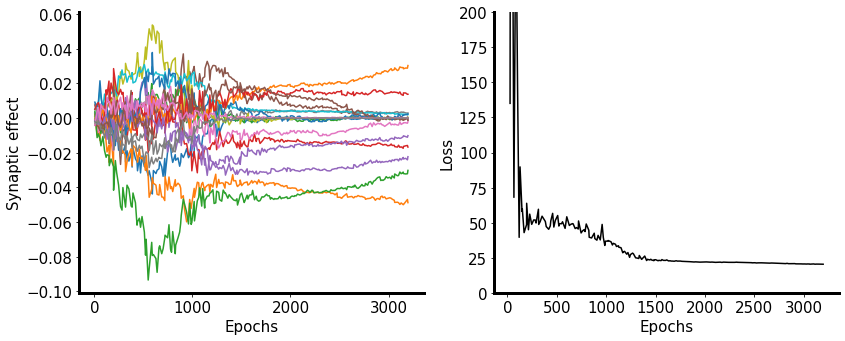

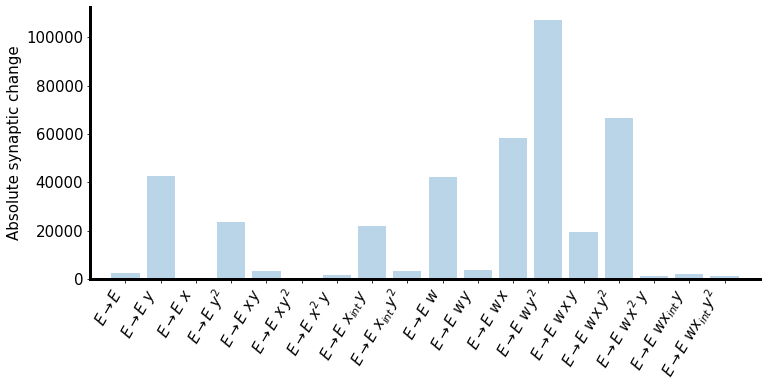

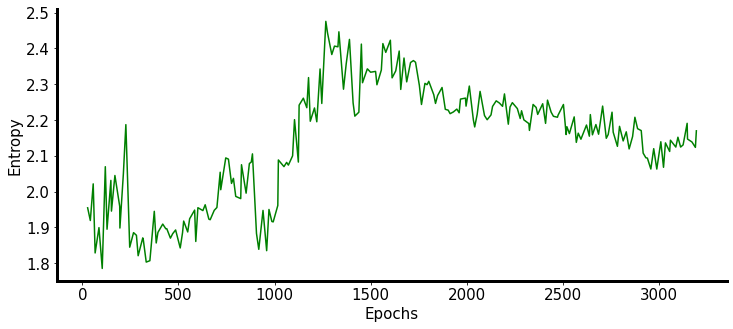

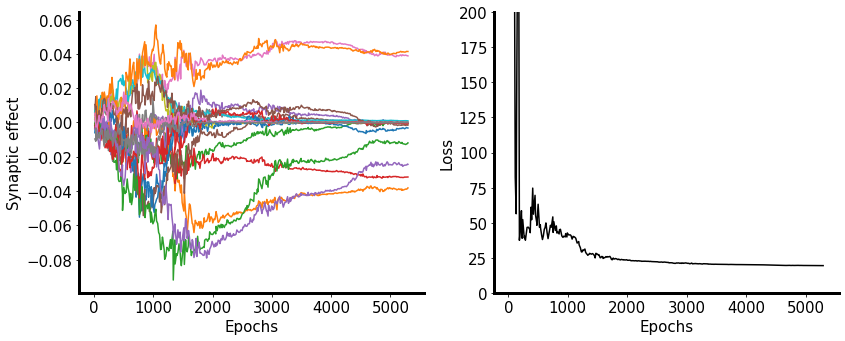

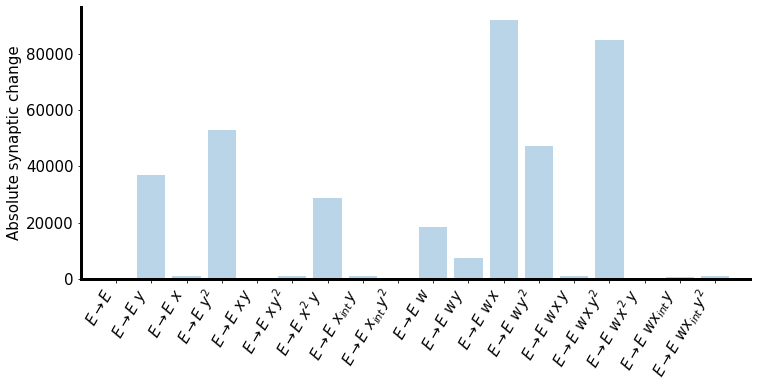

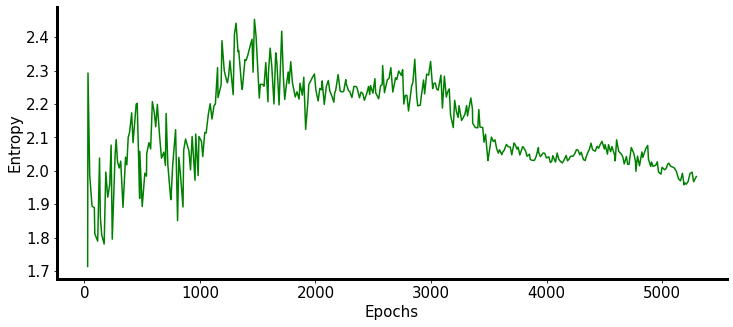

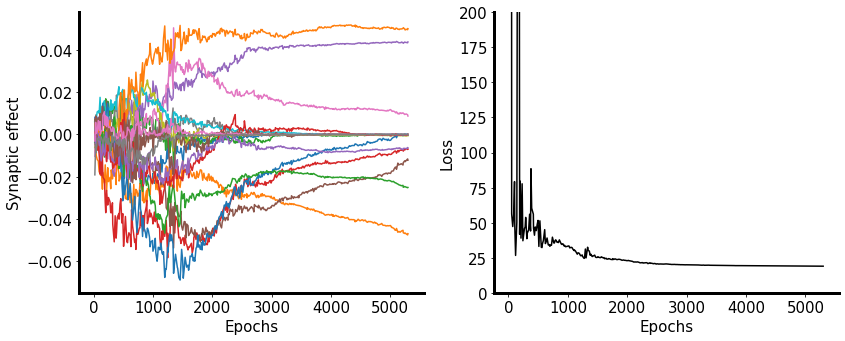

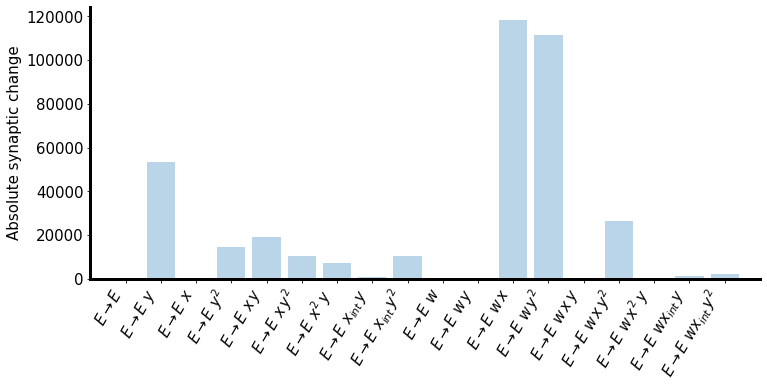

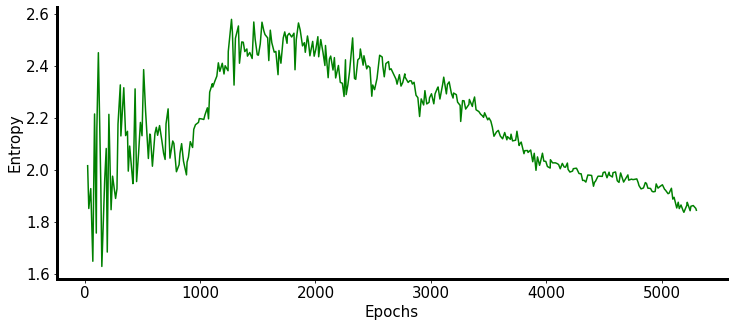

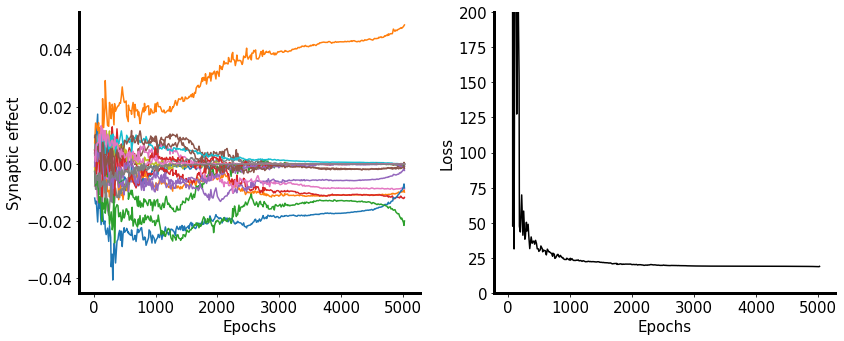

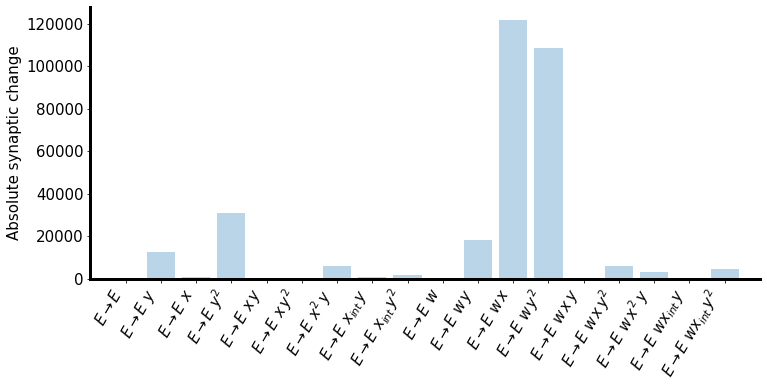

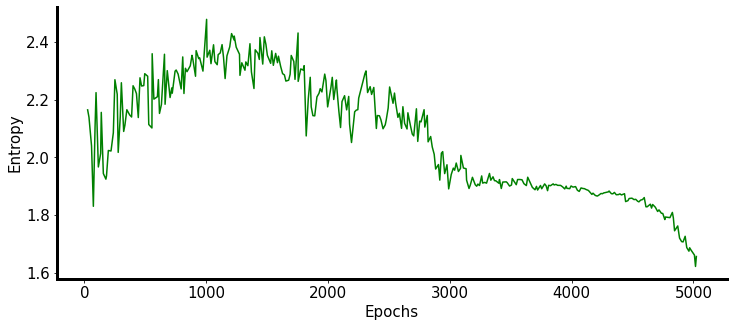

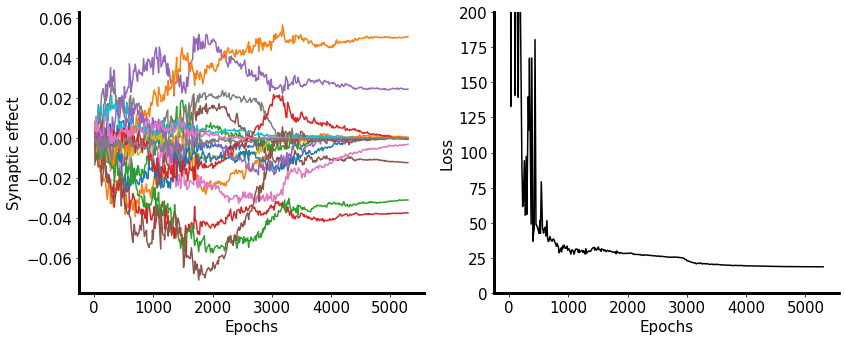

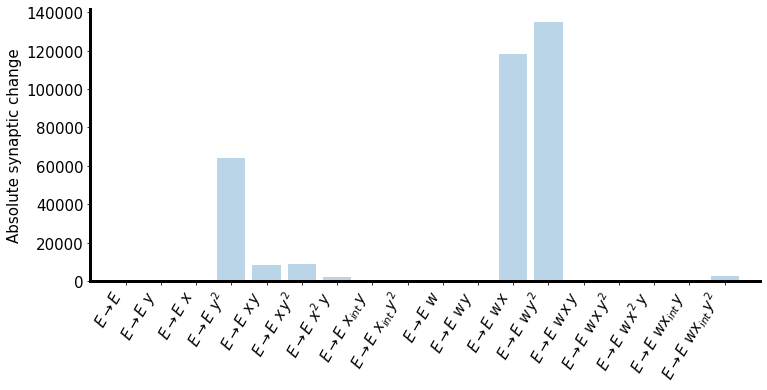

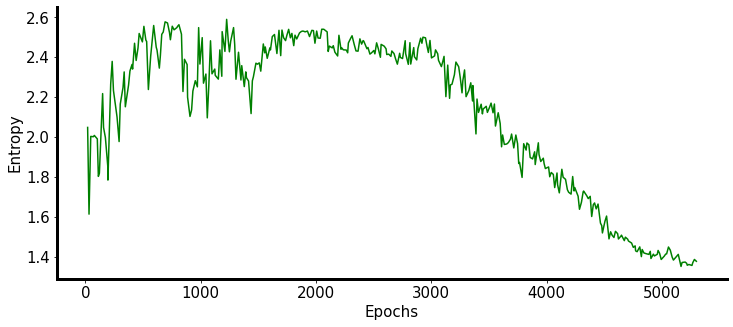

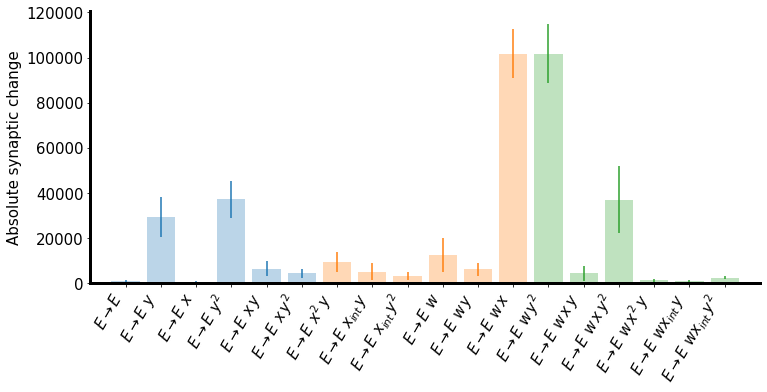

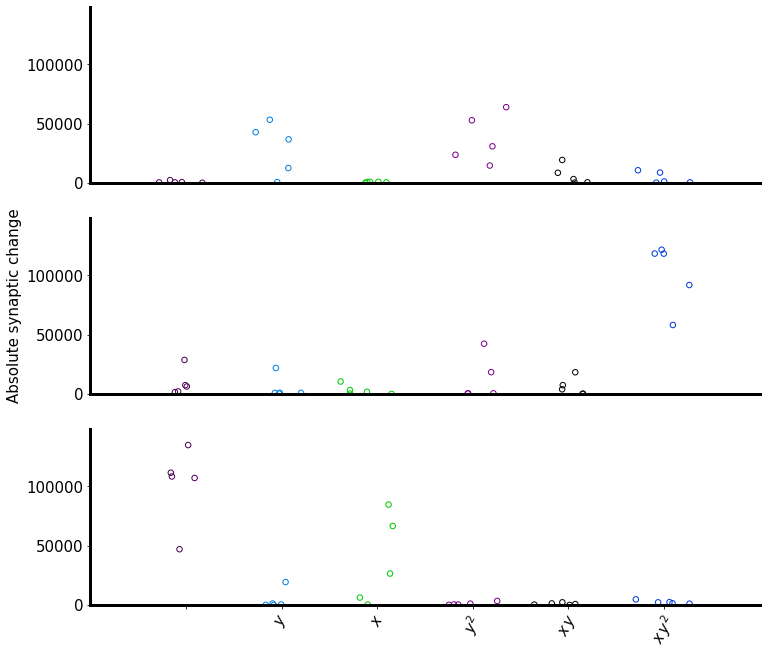

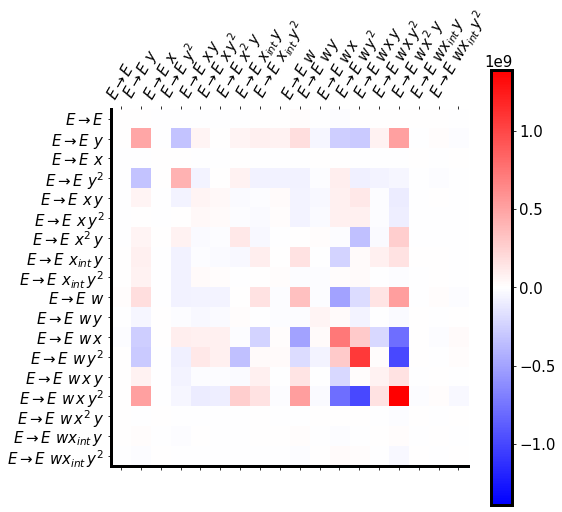

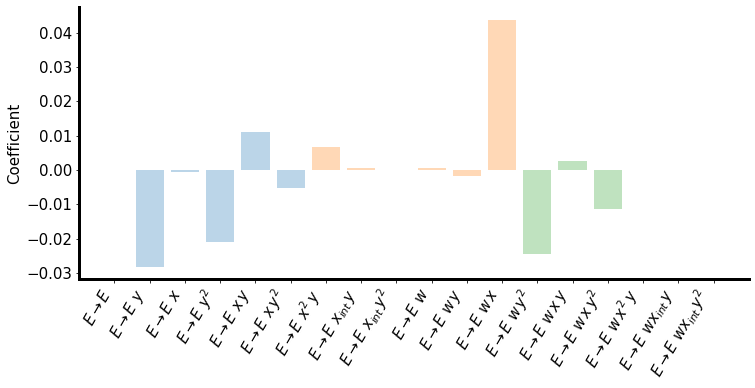

In [3]:
all_files = [
    'seq_ee_jitter_pen_rescaled_batch_30_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_0_2023-01-30_13:39:26.376395',
    'seq_ee_jitter_pen_rescaled_batch_30_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_0_2023-01-30_22:46:28.398161',
    'seq_ee_jitter_pen_rescaled_batch_30_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_0_2023-01-30_23:33:26.121717',
    'seq_ee_jitter_pen_rescaled_batch_30_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_0_2023-01-30_23:33:34.700228',
    'seq_ee_jitter_pen_rescaled_batch_30_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_0_2023-01-30_23:33:38.824199',
]

final_syn_effects = []
final_plasticity_coefs = []

for f in all_files:
    syn_effects_for_f, plasticity_coefs_for_f, best_loss_for_f = plot_all_2(f, 18, 30, n_categories=1)
    if best_loss_for_f < 100:
        print(f'{f}')
        final_syn_effects.append(syn_effects_for_f)
        final_plasticity_coefs.append(plasticity_coefs_for_f)

final_syn_effects = np.stack(final_syn_effects)
final_syn_effect_means = np.mean(final_syn_effects, axis=0)
final_syn_effect_stds = np.std(final_syn_effects, axis=0) / np.sqrt(final_syn_effects.shape[0])

final_plasticity_coef_means = np.mean(np.stack(final_plasticity_coefs), axis=0)

# plot the synaptic effects of each plasticity rule (unsorted by size)
scale = 2
n_categories = 3
fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 2.5 * scale))
format_axs(axs)
partial_rules_len = int(len(final_syn_effect_means) / n_categories)

for l in range(n_categories):
    x = np.arange(partial_rules_len) + l * partial_rules_len
    y = final_syn_effect_means[l * partial_rules_len: (l+1) * partial_rules_len]
    y_err = final_syn_effect_stds[l * partial_rules_len: (l+1) * partial_rules_len]
    axs.bar(x, y, alpha=0.3)
    axs.errorbar(x, y, yerr=y_err, ls='none')
    
axs.set_xticks(np.arange(len(final_syn_effect_means)))
axs.set_xticklabels(rule_names[:len(final_syn_effect_means)], rotation=60, ha='right')
axs.set_ylabel('Absolute synaptic change')
axs.set_xlim(-1, len(final_syn_effect_means))

# plot the synaptic effects of each plasticity rule as scatter plot
scale = 2
fig, axs = plt.subplots(3, 1, figsize=(6 * scale, 5.5 * scale))
format_axs(axs)

cmap = matplotlib.cm.get_cmap('nipy_spectral')
colors = [cmap(x) for x in np.linspace(0, 0.55, final_syn_effects.shape[1])]
np.random.shuffle(colors)

max_val = 0
for i in range(n_categories):
    for j in range(partial_rules_len):
        x = i * partial_rules_len + j
        y = final_syn_effects[:, x]
        axs[i].scatter(j * np.ones(final_syn_effects.shape[0]) + np.random.normal(0, 0.15, final_syn_effects.shape[0]), y, s=30, facecolors='none', edgecolors=colors[j], marker='o')
        
        if np.max(y) > max_val:
            max_val = np.max(y)
    axs[i].set_xlim(-1, partial_rules_len)
    if i < n_categories - 1:
        axs[i].set_xticks([])
        
axs[2].set_xticklabels(general_rule_names, rotation=60)
axs[2].set_xticks(np.arange(partial_rules_len))

axs[1].set_ylabel('Absolute synaptic change')

for i in range(n_categories):
    axs[i].set_ylim(0, max_val * 1.1)

# plot covariance of synaptic changes due to each rule
normed_syn_effect_means = final_syn_effect_means / np.sum(final_syn_effect_means)

fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))
format_axs(axs)
syn_effect_cov_mat = np.cov(np.array(final_syn_effects).T)
max_abs_val = np.max(np.abs(syn_effect_cov_mat))
mappable = axs.matshow(syn_effect_cov_mat, cmap='bwr', vmin=-max_abs_val, vmax=max_abs_val)
plt.colorbar(mappable)
axs.set_xticks(np.arange(len(final_syn_effect_means)))
axs.set_xticklabels(rule_names[:len(final_syn_effect_means)], rotation=60)
axs.set_yticks(np.arange(len(final_syn_effect_means)))
axs.set_yticklabels(rule_names[:len(final_syn_effect_means)], rotation=0)

# plot the coefficients assigned to each plasticity rule (unsorted by size)
scale = 2
fig2, axs2 = plt.subplots(1, 1, figsize=(6 * scale, 2.5 * scale))
format_axs(axs2)

for l in range(n_categories):
    x = np.arange(partial_rules_len) + l * partial_rules_len
    y = final_plasticity_coef_means[l * partial_rules_len: (l+1) * partial_rules_len]
    axs2.bar(x, y, alpha=0.3)
    
axs2.set_xticks(np.arange(len(final_plasticity_coef_means)))
axs2.set_xticklabels(rule_names[:len(final_syn_effect_means)], rotation=60, ha='right')
axs2.set_ylabel('Coefficient')
axs2.set_xlim(-1, len(final_plasticity_coef_means))

seq_ee_jitter_pen_rescaled_batch_30_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_2023-01-30_14:28:19.348344
seq_ee_jitter_pen_rescaled_batch_30_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_2023-01-30_22:35:39.275445
seq_ee_jitter_pen_rescaled_batch_30_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_2023-01-30_22:46:30.191639
seq_ee_jitter_pen_rescaled_batch_30_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_2023-01-31_00:22:38.433098
seq_ee_jitter_pen_rescaled_batch_30_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_2023-01-31_00:22:39.036128
seq_ee_jitter_pen_rescaled_batch_30_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_2023-01-31_00:34:04.230647


(-1.0, 18.0)

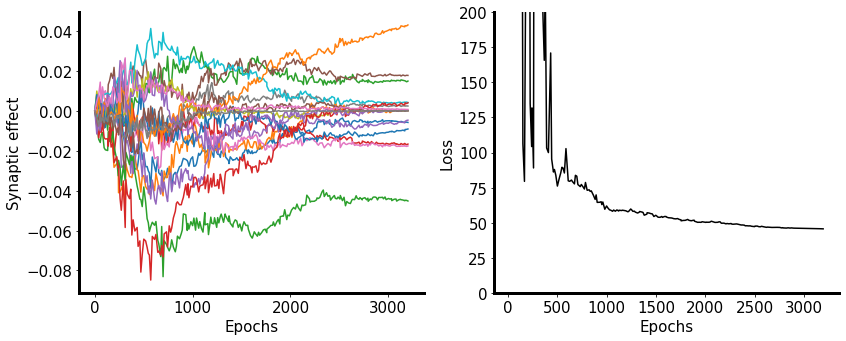

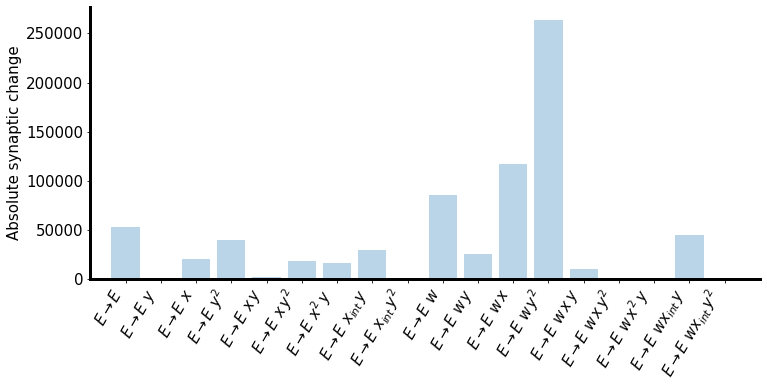

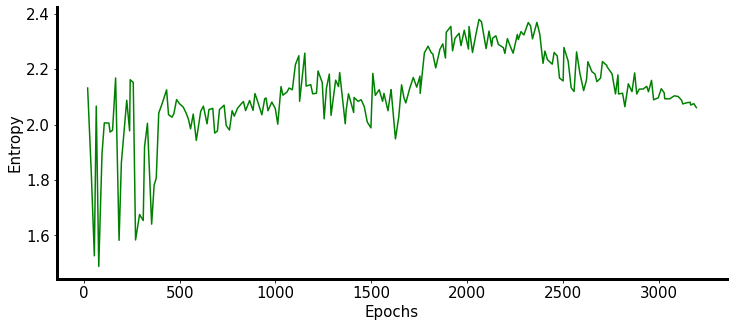

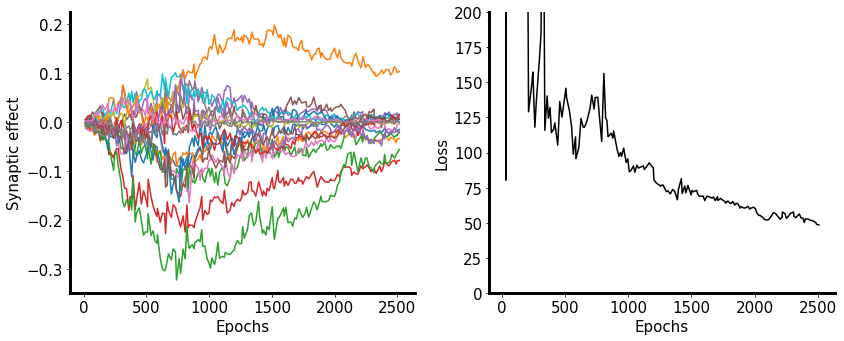

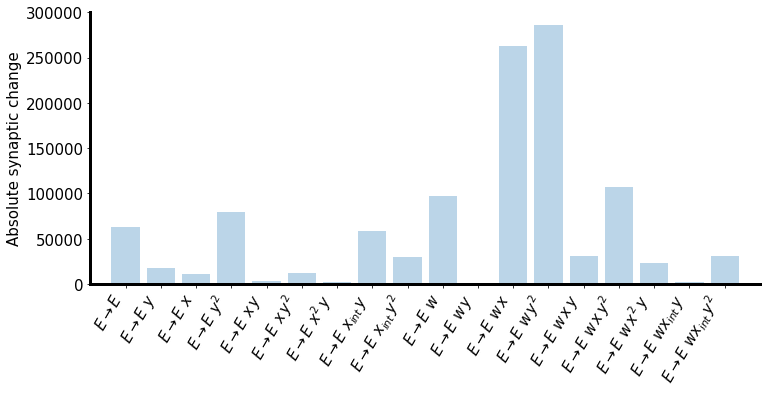

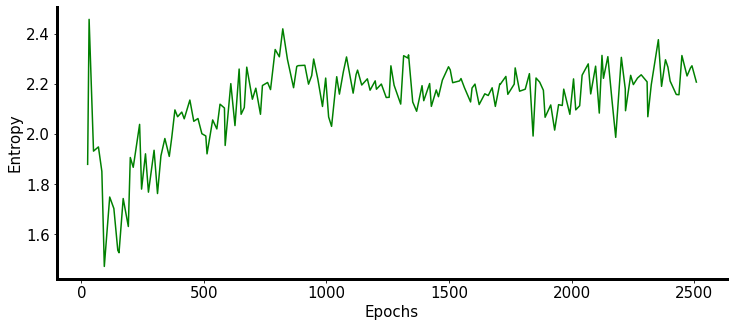

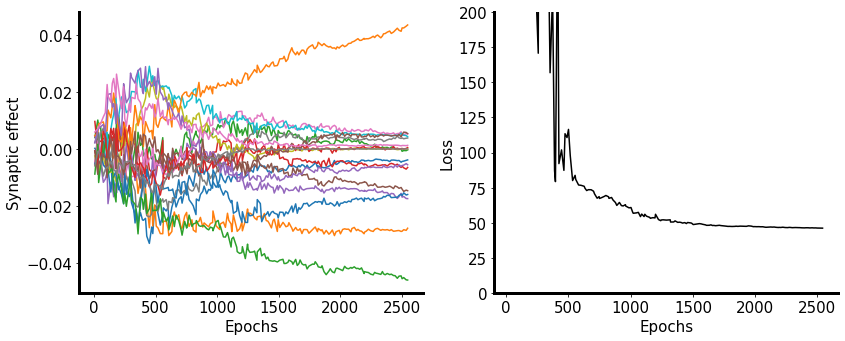

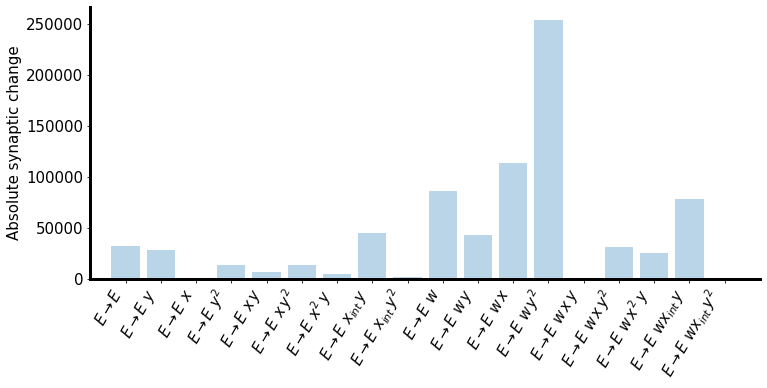

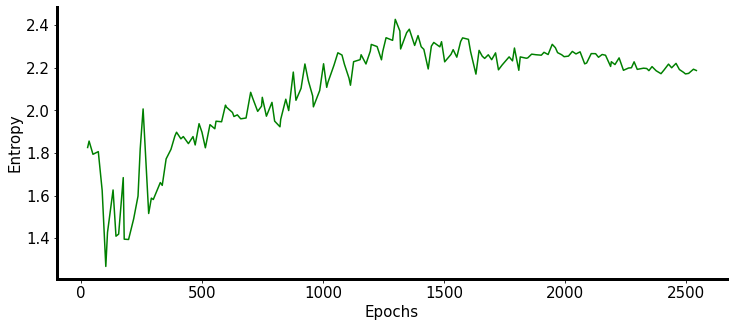

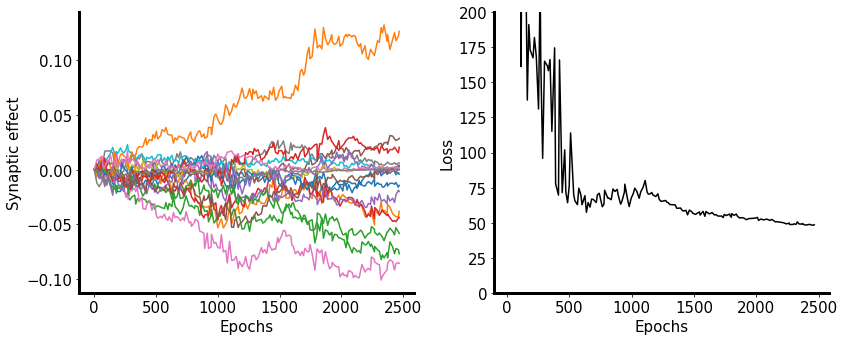

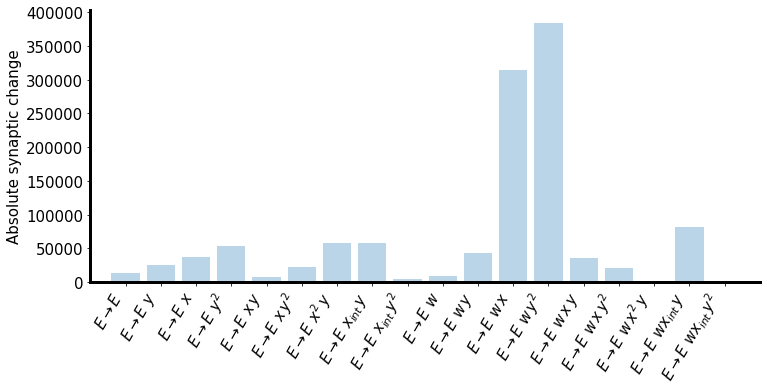

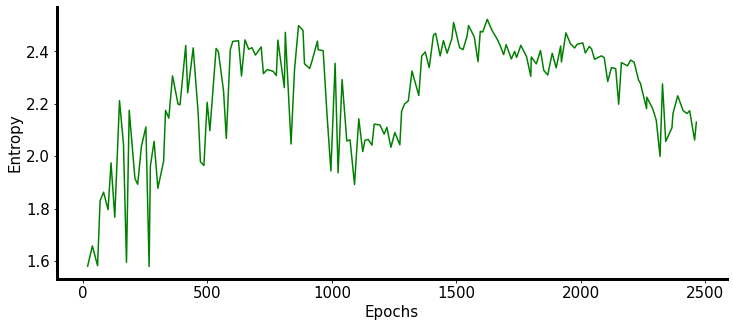

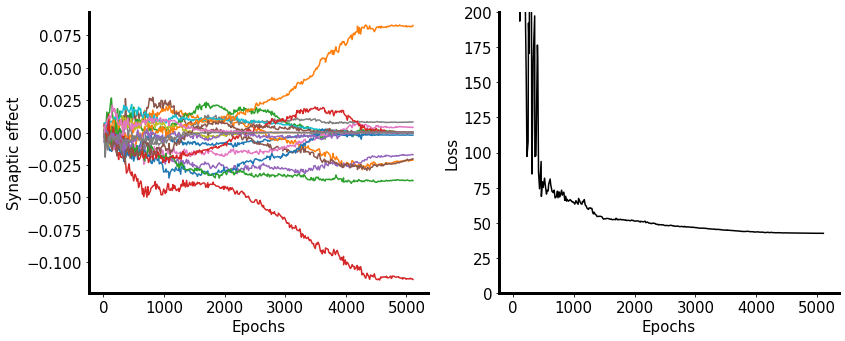

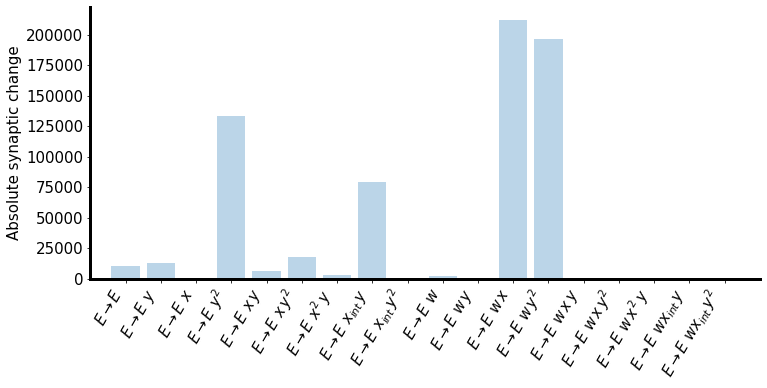

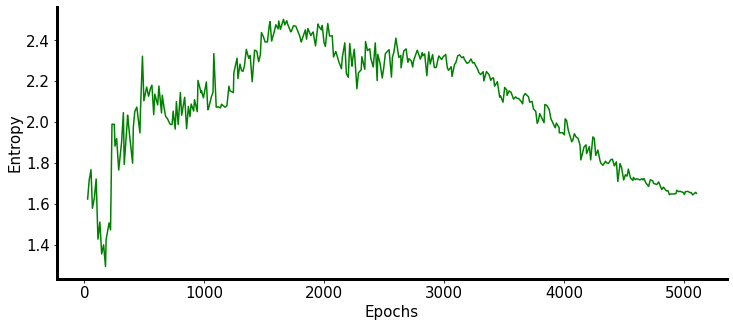

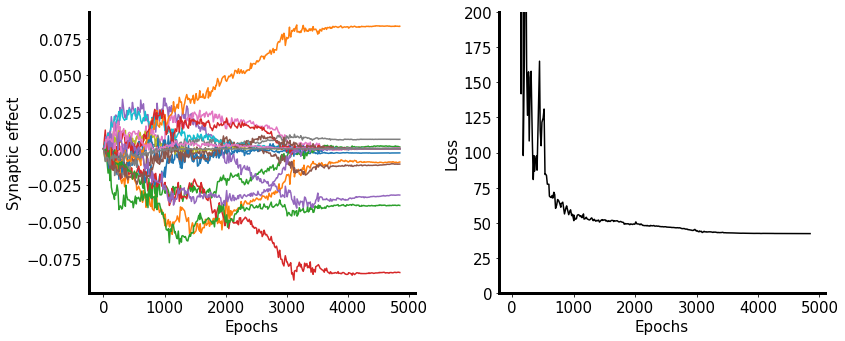

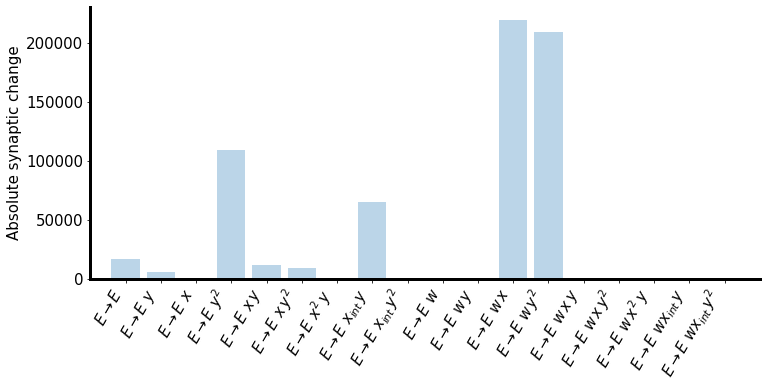

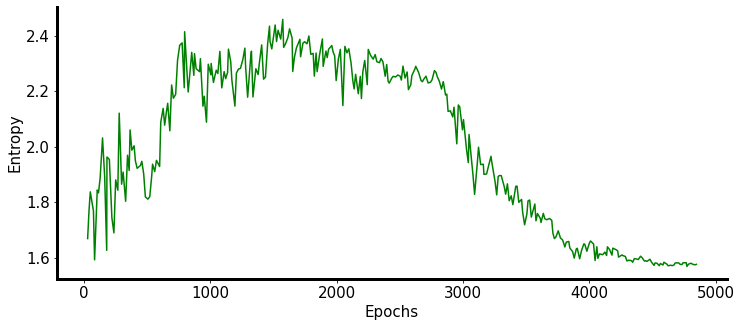

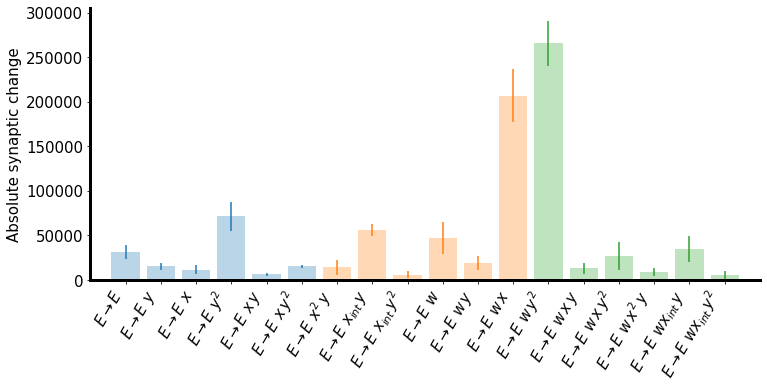

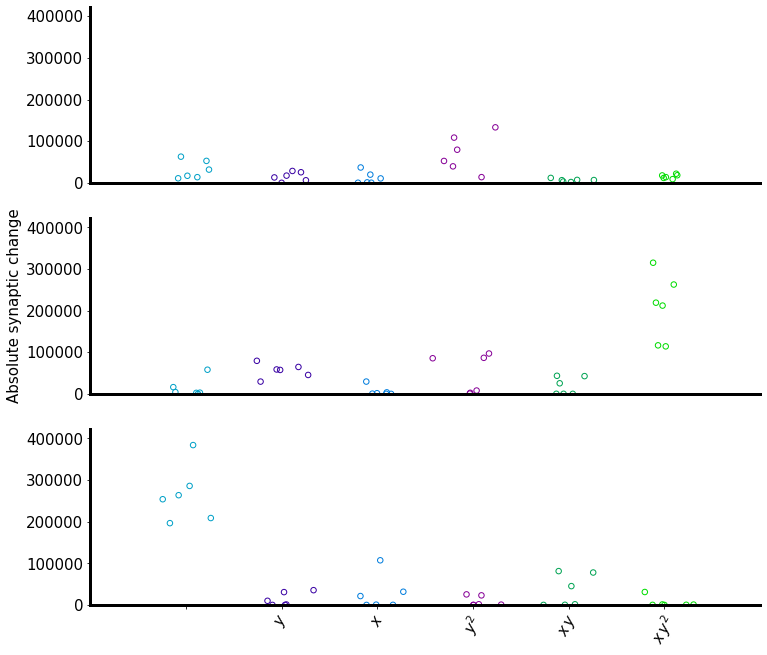

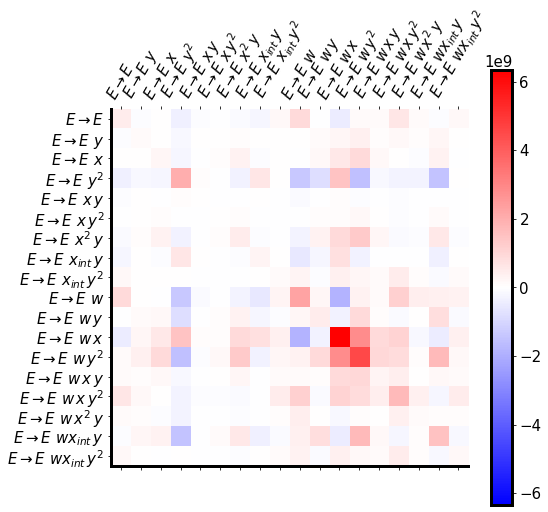

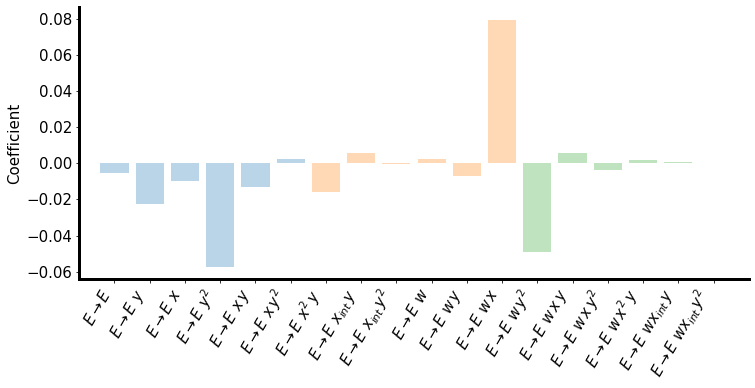

In [6]:
all_files = [
    'seq_ee_jitter_pen_rescaled_batch_30_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_2023-01-30_14:28:19.348344',
    'seq_ee_jitter_pen_rescaled_batch_30_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_2023-01-30_22:35:39.275445',
    'seq_ee_jitter_pen_rescaled_batch_30_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_2023-01-30_22:46:30.191639',
    'seq_ee_jitter_pen_rescaled_batch_30_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_2023-01-31_00:22:38.433098',
    'seq_ee_jitter_pen_rescaled_batch_30_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_2023-01-31_00:22:39.036128',
    'seq_ee_jitter_pen_rescaled_batch_30_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_2023-01-31_00:34:04.230647',
]

final_syn_effects = []
final_plasticity_coefs = []


for f in all_files:
    syn_effects_for_f, plasticity_coefs_for_f, best_loss_for_f = plot_all_2(f, 18, 30, n_categories=1)
    if best_loss_for_f < 100:
        print(f'{f}')
        final_syn_effects.append(syn_effects_for_f)
        final_plasticity_coefs.append(plasticity_coefs_for_f)

final_syn_effects = np.stack(final_syn_effects)
final_syn_effect_means = np.mean(final_syn_effects, axis=0)
final_syn_effect_stds = np.std(final_syn_effects, axis=0) / np.sqrt(final_syn_effects.shape[0])

final_plasticity_coef_means = np.mean(np.stack(final_plasticity_coefs), axis=0)

# plot the synaptic effects of each plasticity rule (unsorted by size)
scale = 2
n_categories = 3
fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 2.5 * scale))
format_axs(axs)
partial_rules_len = int(len(final_syn_effect_means) / n_categories)

for l in range(n_categories):
    x = np.arange(partial_rules_len) + l * partial_rules_len
    y = final_syn_effect_means[l * partial_rules_len: (l+1) * partial_rules_len]
    y_err = final_syn_effect_stds[l * partial_rules_len: (l+1) * partial_rules_len]
    axs.bar(x, y, alpha=0.3)
    axs.errorbar(x, y, yerr=y_err, ls='none')
    
axs.set_xticks(np.arange(len(final_syn_effect_means)))
axs.set_xticklabels(rule_names[:len(final_syn_effect_means)], rotation=60, ha='right')
axs.set_ylabel('Absolute synaptic change')
axs.set_xlim(-1, len(final_syn_effect_means))

# plot the synaptic effects of each plasticity rule as scatter plot
scale = 2
fig, axs = plt.subplots(3, 1, figsize=(6 * scale, 5.5 * scale))
format_axs(axs)

cmap = matplotlib.cm.get_cmap('nipy_spectral')
colors = [cmap(x) for x in np.linspace(0, 0.55, final_syn_effects.shape[1])]
np.random.shuffle(colors)

max_val = 0
for i in range(n_categories):
    for j in range(partial_rules_len):
        x = i * partial_rules_len + j
        y = final_syn_effects[:, x]
        axs[i].scatter(j * np.ones(final_syn_effects.shape[0]) + np.random.normal(0, 0.15, final_syn_effects.shape[0]), y, s=30, facecolors='none', edgecolors=colors[j], marker='o')
        
        if np.max(y) > max_val:
            max_val = np.max(y)
    axs[i].set_xlim(-1, partial_rules_len)
    if i < n_categories - 1:
        axs[i].set_xticks([])
        
axs[2].set_xticklabels(general_rule_names, rotation=60)
axs[2].set_xticks(np.arange(partial_rules_len))

axs[1].set_ylabel('Absolute synaptic change')

for i in range(n_categories):
    axs[i].set_ylim(0, max_val * 1.1)

# plot covariance of synaptic changes due to each rule
normed_syn_effect_means = final_syn_effect_means / np.sum(final_syn_effect_means)

fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))
format_axs(axs)
syn_effect_cov_mat = np.cov(np.array(final_syn_effects).T)
max_abs_val = np.max(np.abs(syn_effect_cov_mat))
mappable = axs.matshow(syn_effect_cov_mat, cmap='bwr', vmin=-max_abs_val, vmax=max_abs_val)
plt.colorbar(mappable)
axs.set_xticks(np.arange(len(final_syn_effect_means)))
axs.set_xticklabels(rule_names[:len(final_syn_effect_means)], rotation=60)
axs.set_yticks(np.arange(len(final_syn_effect_means)))
axs.set_yticklabels(rule_names[:len(final_syn_effect_means)], rotation=0)

# plot the coefficients assigned to each plasticity rule (unsorted by size)
scale = 2
fig2, axs2 = plt.subplots(1, 1, figsize=(6 * scale, 2.5 * scale))
format_axs(axs2)

for l in range(n_categories):
    x = np.arange(partial_rules_len) + l * partial_rules_len
    y = final_plasticity_coef_means[l * partial_rules_len: (l+1) * partial_rules_len]
    axs2.bar(x, y, alpha=0.3)
    
axs2.set_xticks(np.arange(len(final_plasticity_coef_means)))
axs2.set_xticklabels(rule_names[:len(final_syn_effect_means)], rotation=60, ha='right')
axs2.set_ylabel('Coefficient')
axs2.set_xlim(-1, len(final_plasticity_coef_means))

seq_syn_effects_tracked_2_batch_20_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_2023-01-03_14:09:03.835156
seq_syn_effects_tracked_2_batch_20_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_2023-01-03_14:09:04.704892
seq_syn_effects_tracked_2_batch_20_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_2023-01-03_14:09:17.223324
seq_syn_effects_tracked_2_batch_20_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_2023-01-03_14:09:35.703655
seq_syn_effects_tracked_2_batch_20_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_2023-01-03_14:09:35.703661
seq_syn_effects_tracked_3_batch_20_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_2023-01-06_14:58:44.629392
seq_syn_effects_tracked_3_batch_20_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_2023-01-06_14:58:44.629779
seq_syn_effects_tracked_3_batch_20_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_2023-01-06_14:58:58.197033
seq_syn_effects_tracked_3_batch_20_STD_EXPL_0.005_FIXED_True_L1_

(-1.0, 42.0)

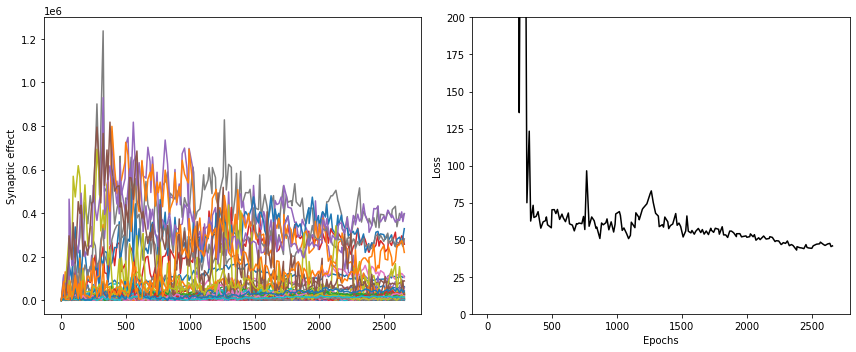

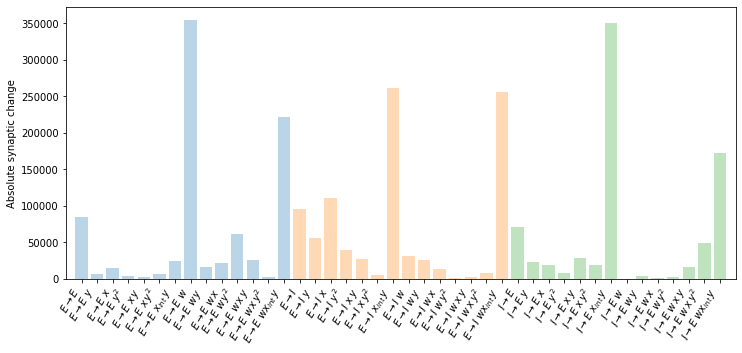

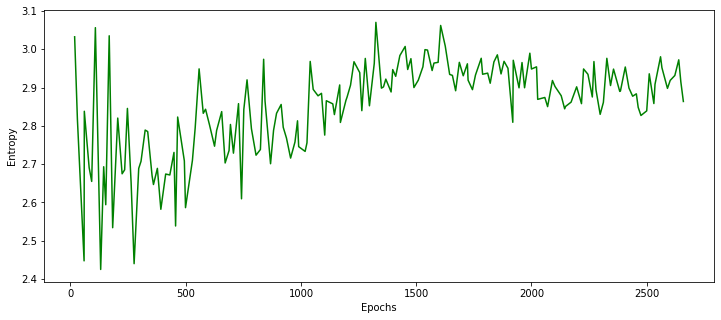

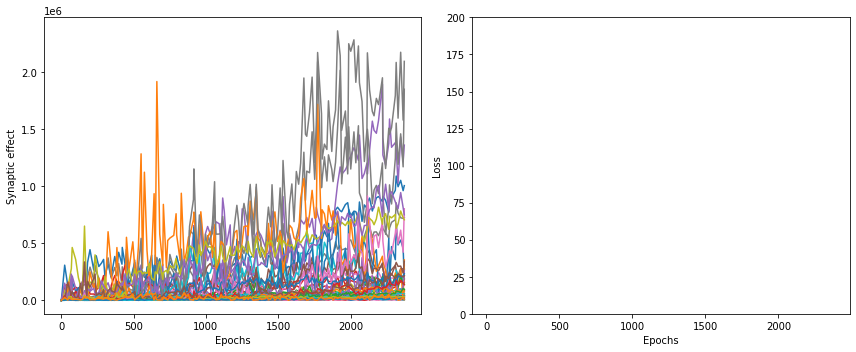

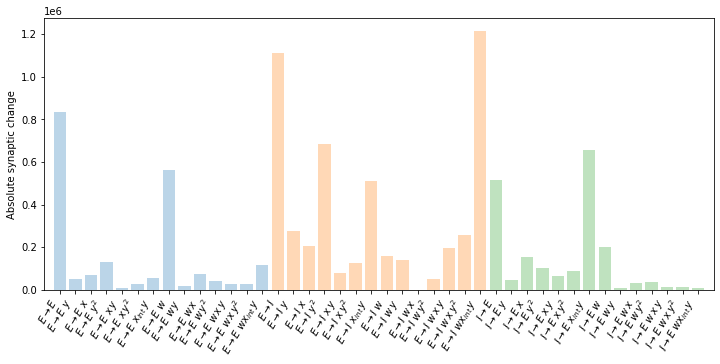

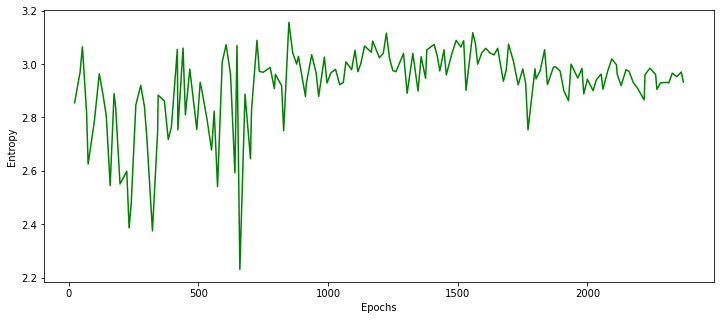

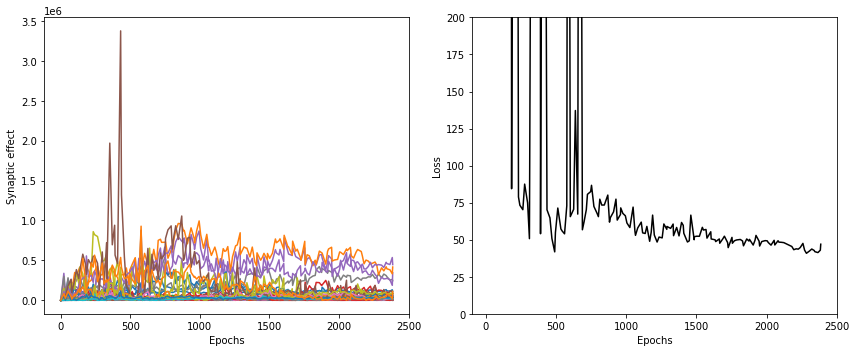

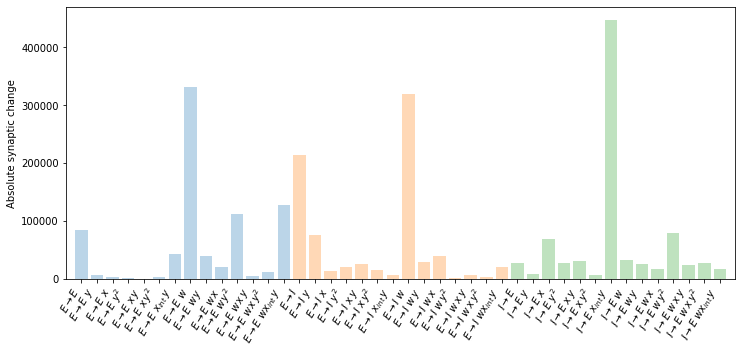

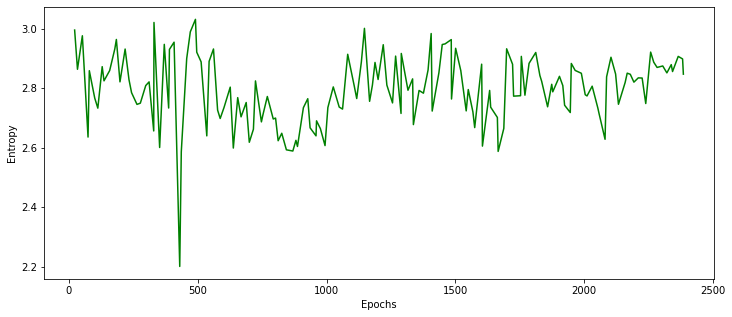

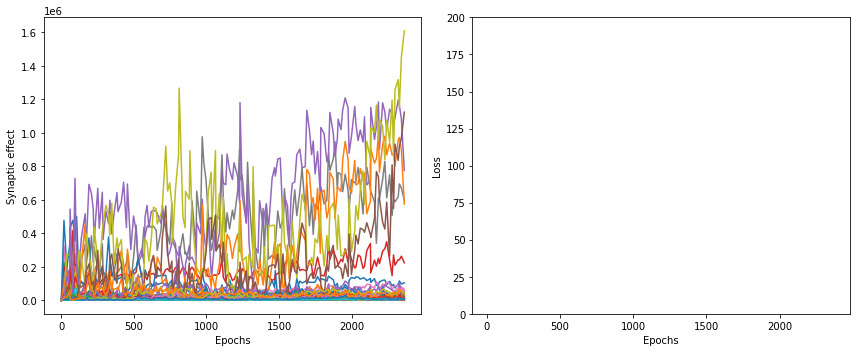

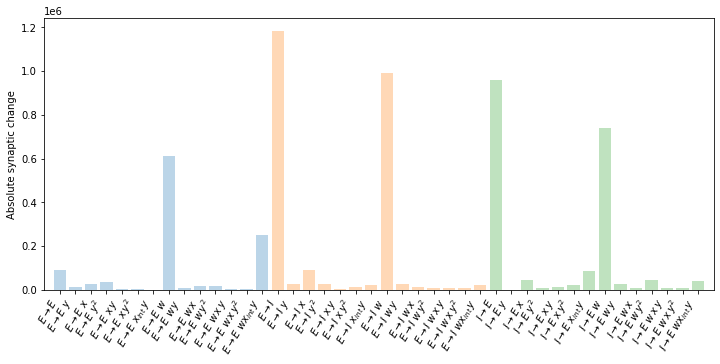

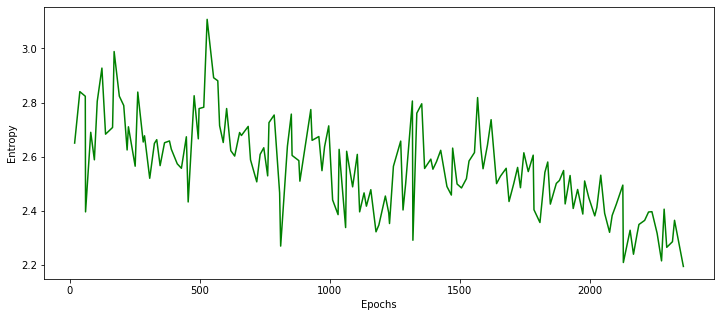

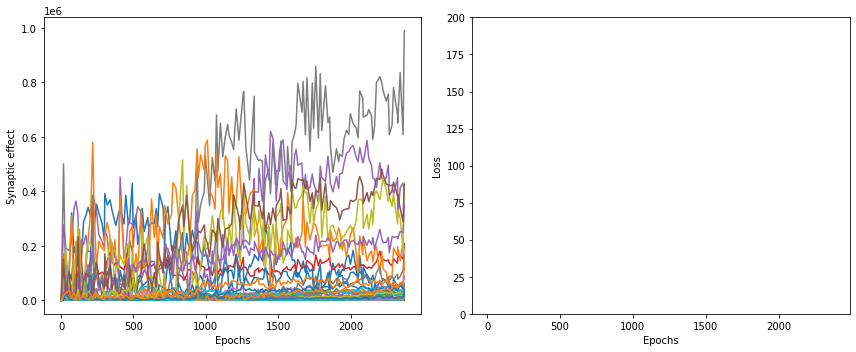

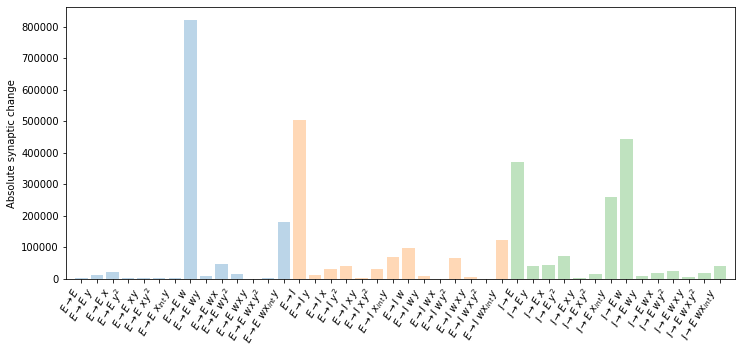

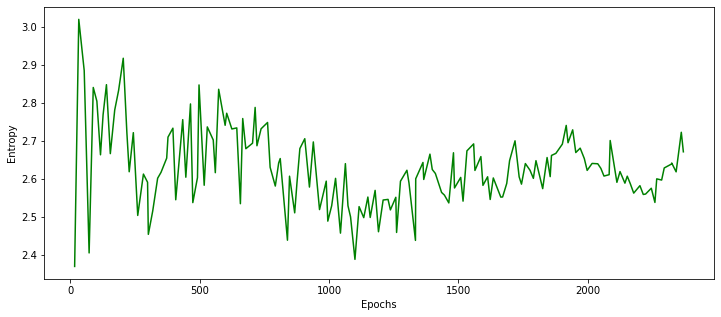

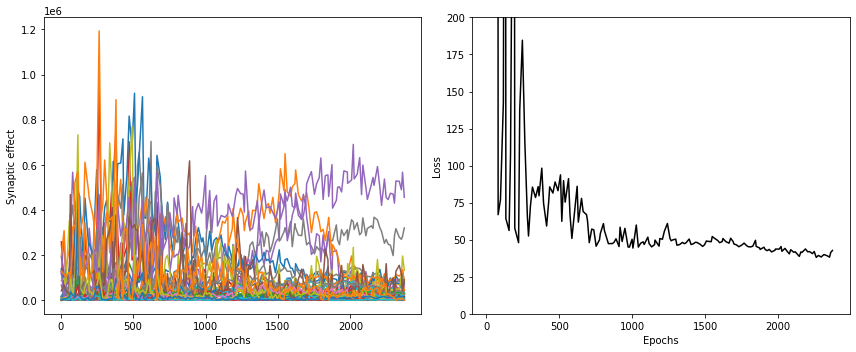

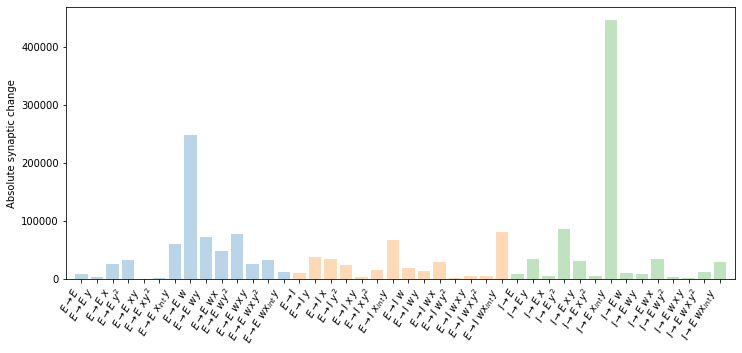

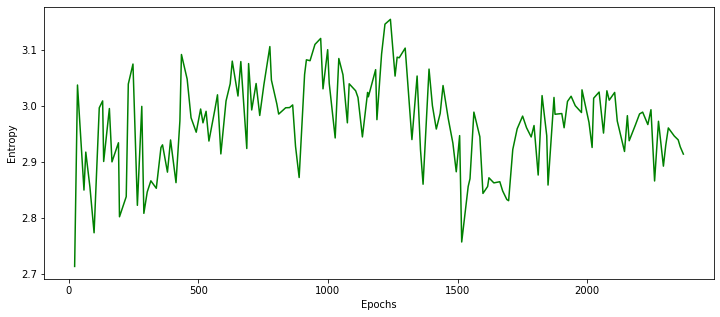

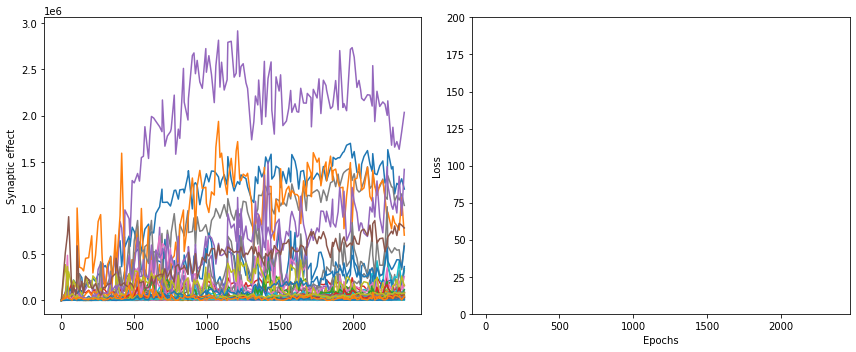

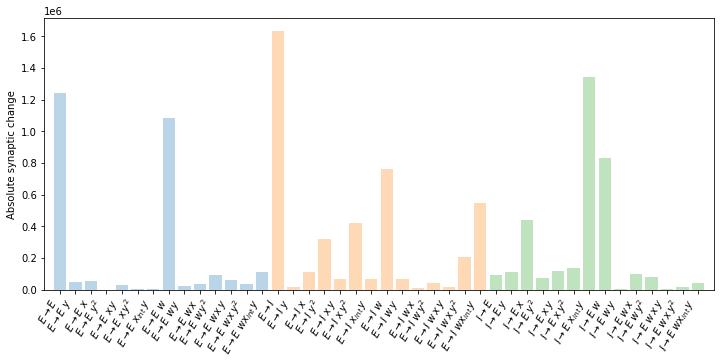

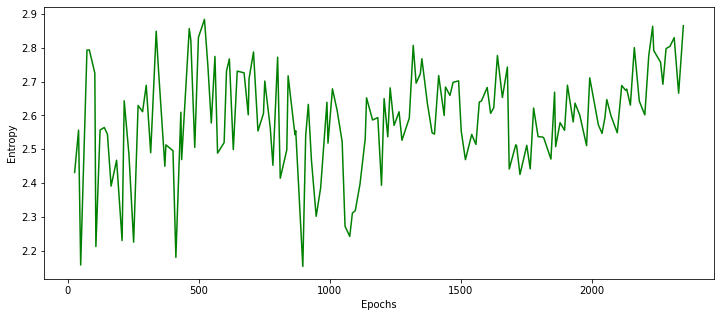

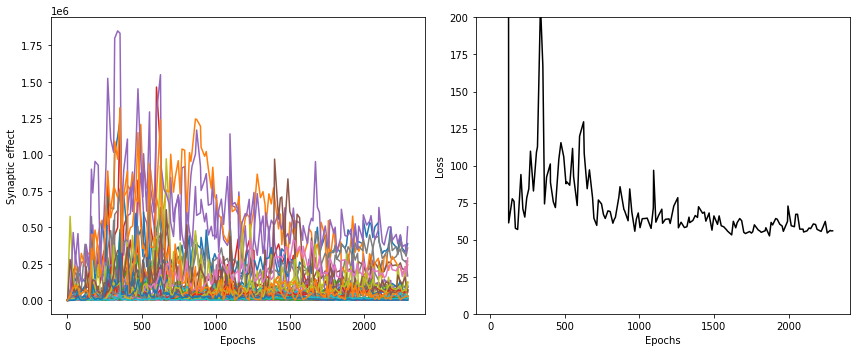

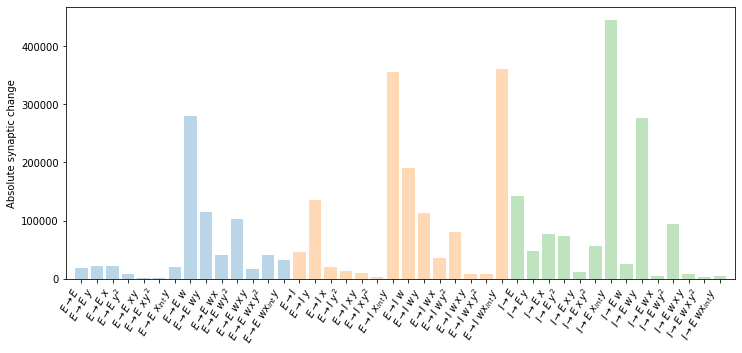

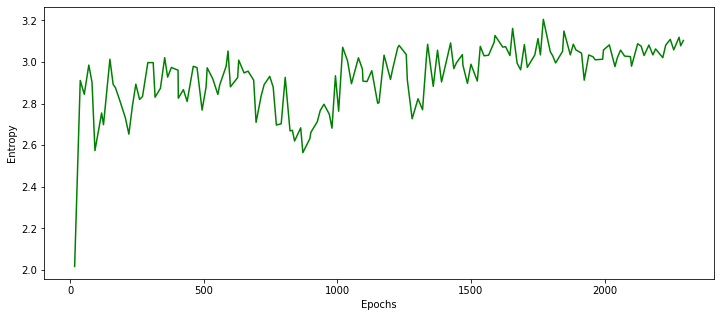

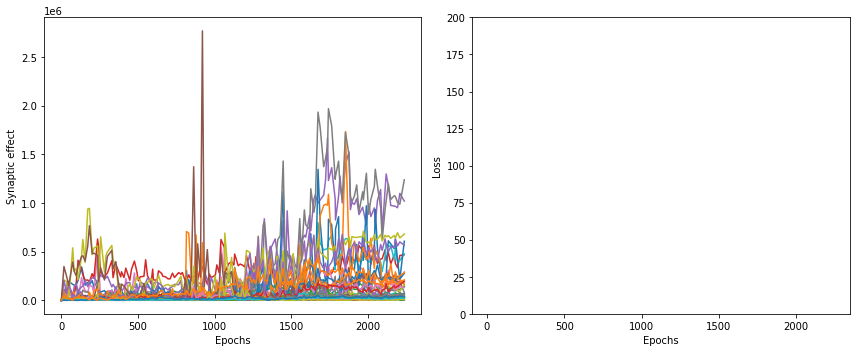

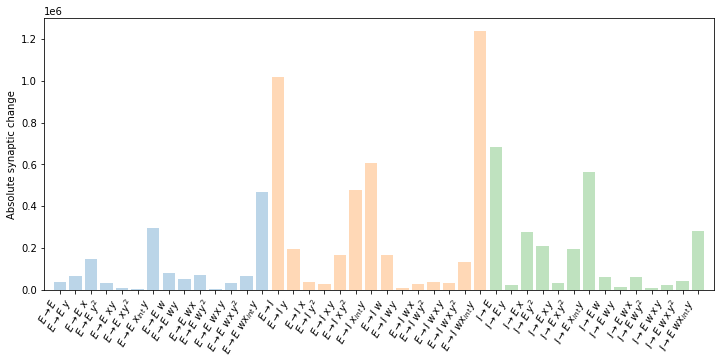

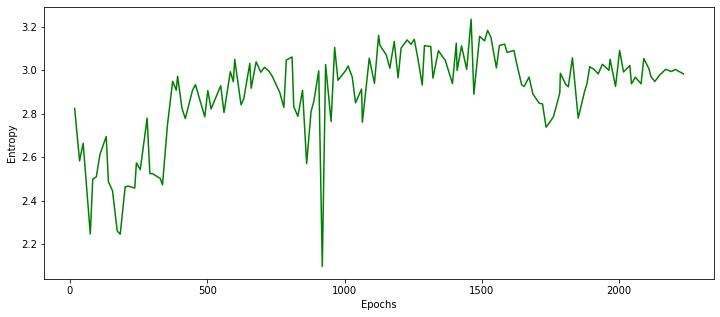

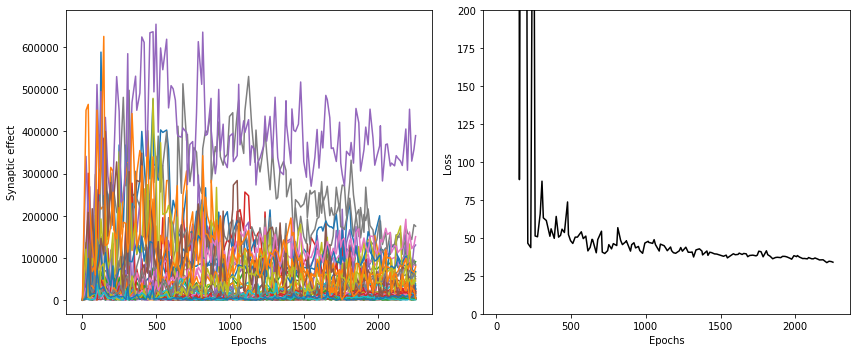

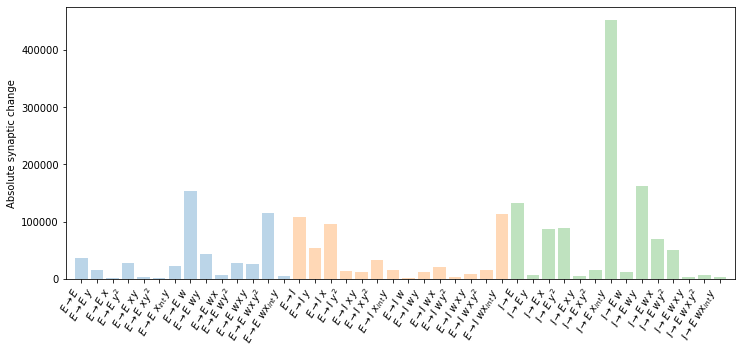

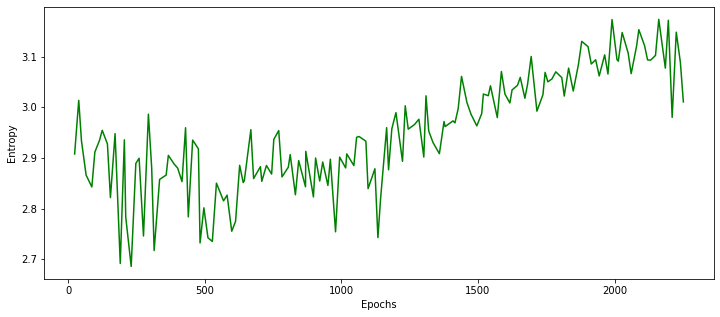

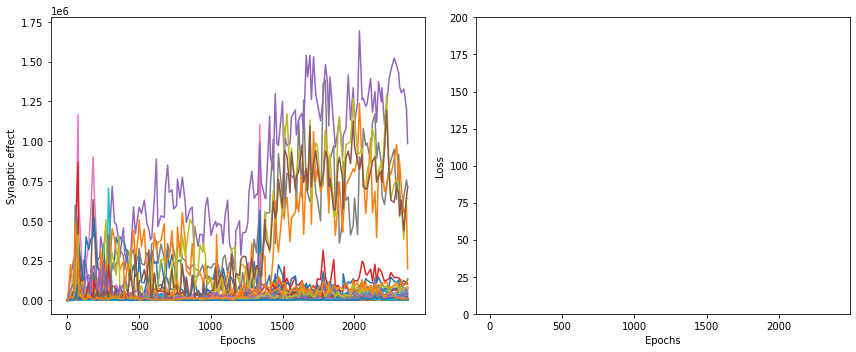

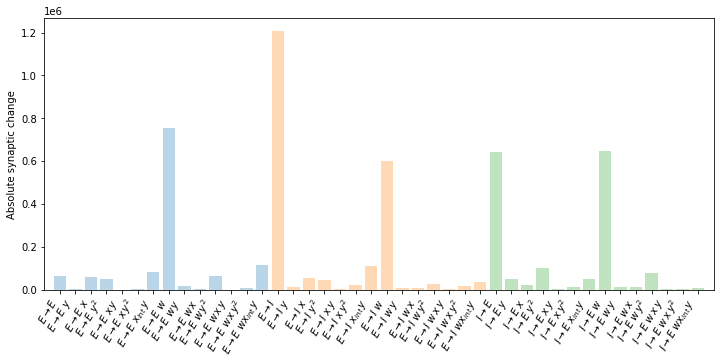

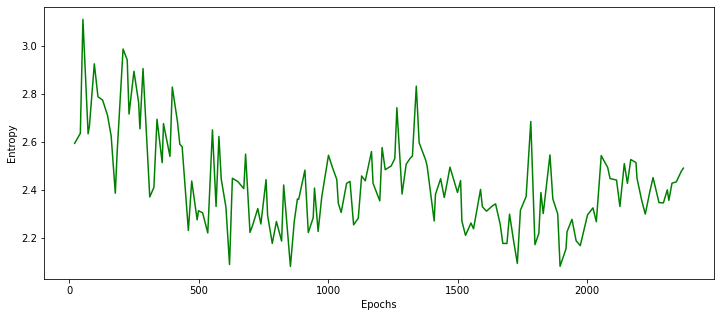

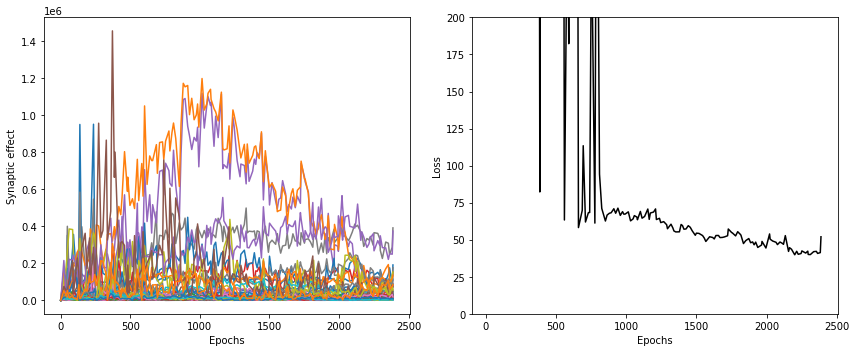

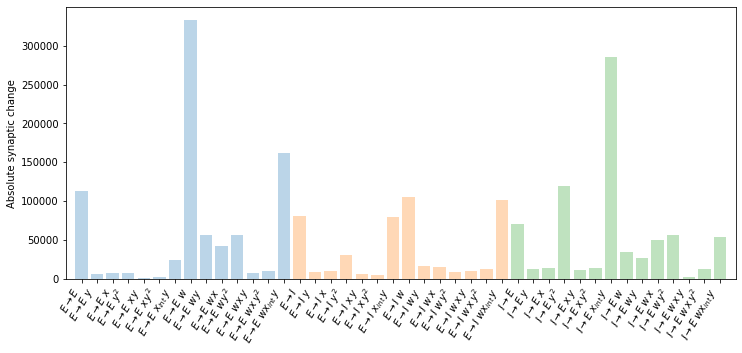

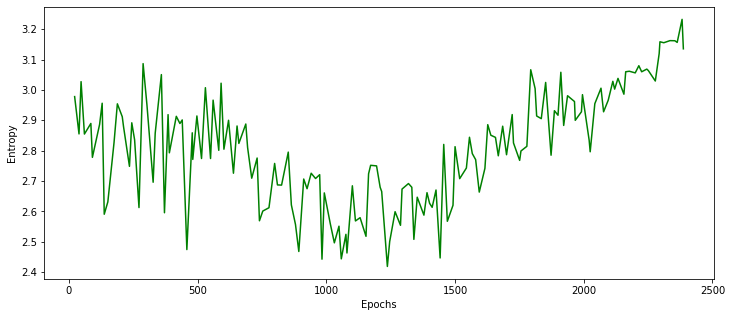

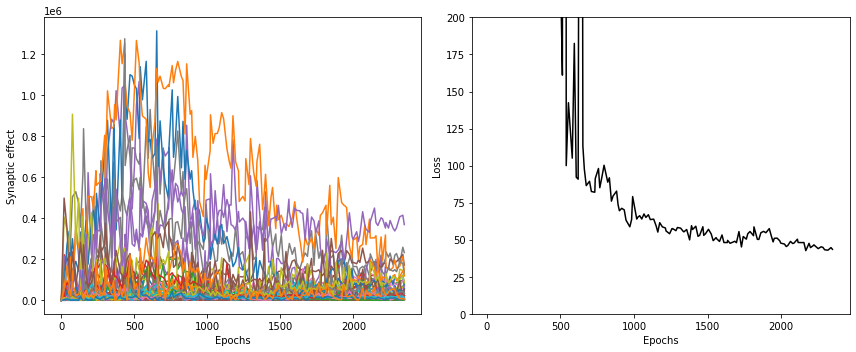

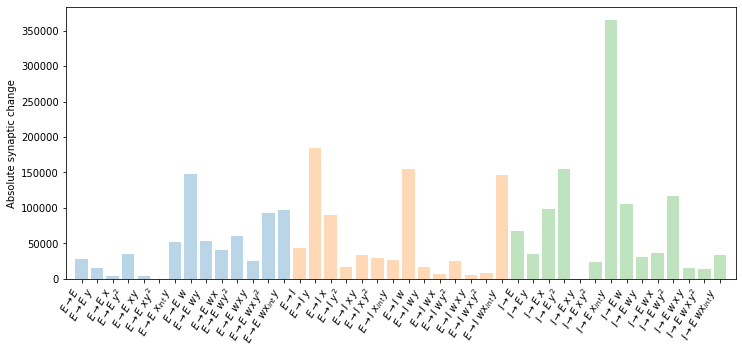

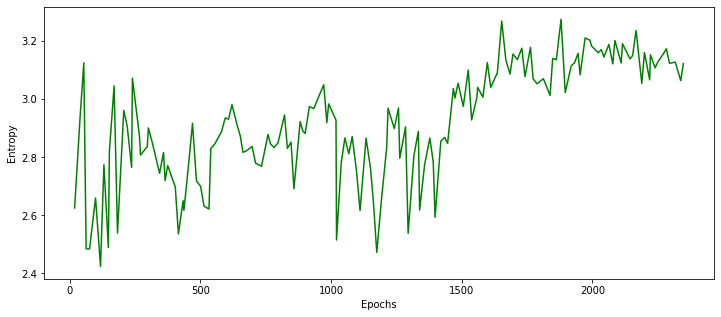

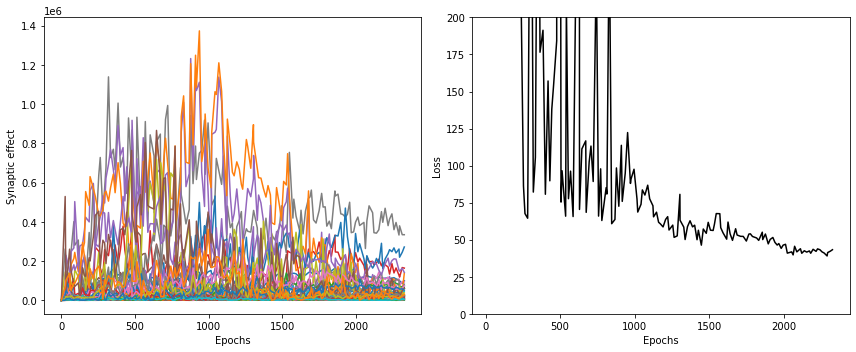

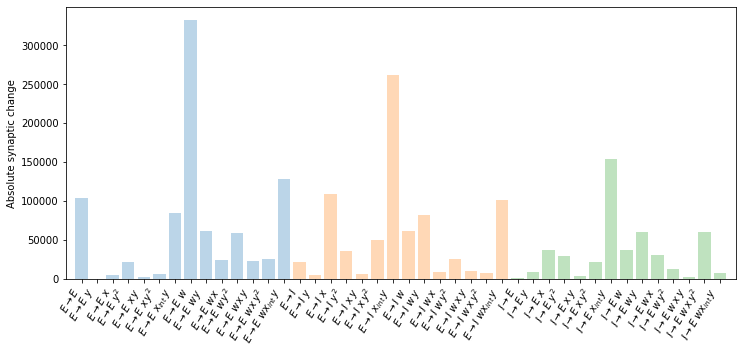

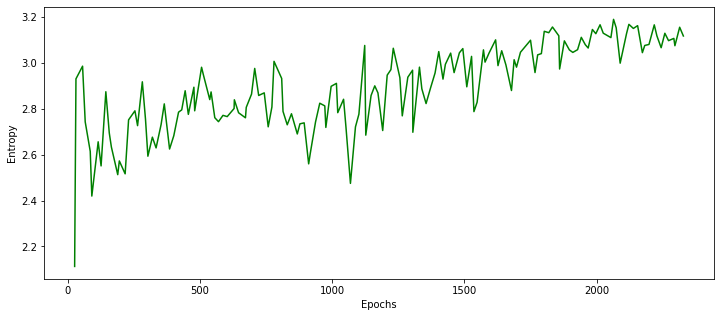

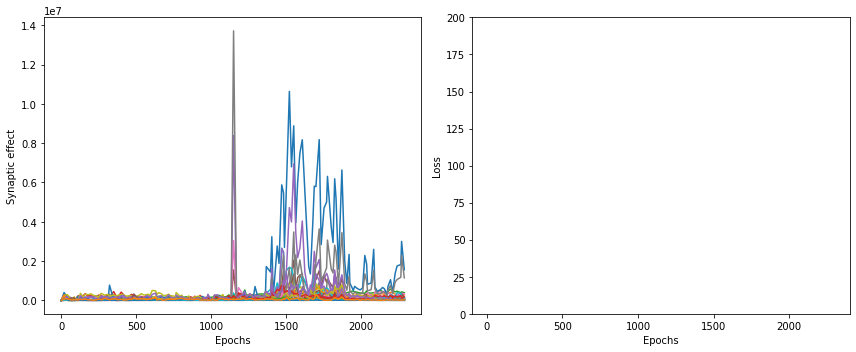

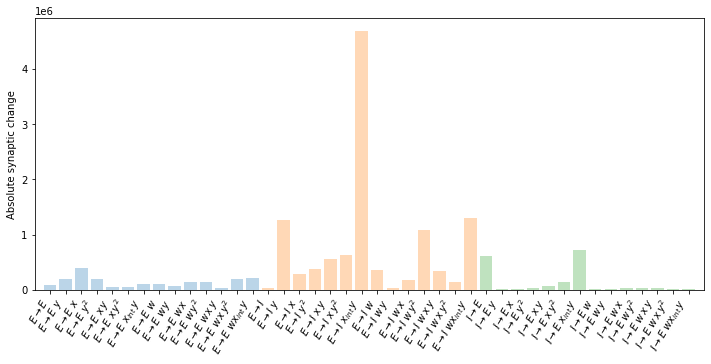

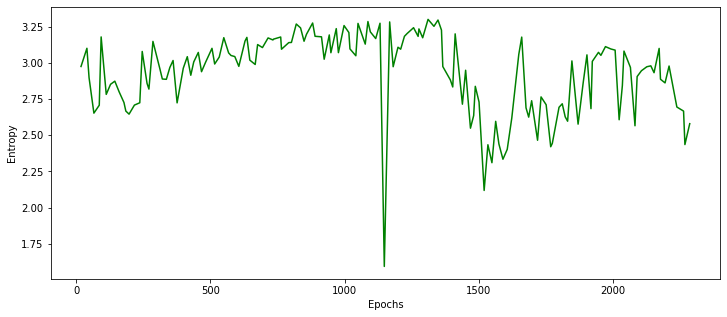

In [ ]:
all_files = [
    'seq_syn_effects_tracked_2_batch_20_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_2023-01-03_14:09:03.835156',
    'seq_syn_effects_tracked_2_batch_20_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_2023-01-03_14:09:03.864367',
    'seq_syn_effects_tracked_2_batch_20_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_2023-01-03_14:09:04.704892',
    'seq_syn_effects_tracked_2_batch_20_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_2023-01-03_14:09:04.704988',
    'seq_syn_effects_tracked_2_batch_20_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_2023-01-03_14:09:04.704990',
    'seq_syn_effects_tracked_2_batch_20_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_2023-01-03_14:09:17.223324',
    'seq_syn_effects_tracked_2_batch_20_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_2023-01-03_14:09:17.228308',
    'seq_syn_effects_tracked_2_batch_20_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_2023-01-03_14:09:35.703655',
    'seq_syn_effects_tracked_2_batch_20_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_2023-01-03_14:09:35.703656',
    'seq_syn_effects_tracked_2_batch_20_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_2023-01-03_14:09:35.703661',
    'seq_syn_effects_tracked_3_batch_20_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_2023-01-06_14:58:44.627834',
    'seq_syn_effects_tracked_3_batch_20_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_2023-01-06_14:58:44.629392',
    'seq_syn_effects_tracked_3_batch_20_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_2023-01-06_14:58:44.629779',
    'seq_syn_effects_tracked_3_batch_20_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_2023-01-06_14:58:58.197033', 
    'seq_syn_effects_tracked_3_batch_20_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_2023-01-06_14:58:58.197035',
    'seq_syn_effects_tracked_3_batch_20_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_2023-01-06_14:58:58.197432',
    'seq_syn_effects_tracked_3_batch_20_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_2023-01-06_14:58:58.197776',
    'seq_syn_effects_tracked_3_batch_20_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_2023-01-06_14:58:58.197778',
    'seq_syn_effects_tracked_3_batch_20_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_2023-01-06_14:58:58.197855',
    'seq_syn_effects_tracked_3_batch_20_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_2023-01-06_14:59:07.797345',
]

final_syn_effects = []
final_plasticity_coefs = []

for f in all_files:
    syn_effects_for_f, plasticity_coefs_for_f, best_loss_for_f = plot_all_2(f, 42, 20, yscale=2e6, n_categories=3)
    if best_loss_for_f < 60:
        print(f'{f}')
        final_syn_effects.append(syn_effects_for_f)
        final_plasticity_coefs.append(plasticity_coefs_for_f)
    
final_syn_effect_means = np.mean(np.stack(final_syn_effects), axis=0)
final_syn_effect_stds = np.std(np.stack(final_syn_effects), axis=0) / np.sqrt(9)

final_plasticity_coef_means = np.mean(np.stack(final_plasticity_coefs), axis=0)

# plot the synaptic effects of each plasticity rule (unsorted by size)
scale = 2
n_categories = 3
fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 2.5 * scale))
partial_rules_len = int(len(final_syn_effect_means) / n_categories)

for l in range(n_categories):
    x = np.arange(partial_rules_len) + l * partial_rules_len
    y = final_syn_effect_means[l * partial_rules_len: (l+1) * partial_rules_len]
    y_err = final_syn_effect_stds[l * partial_rules_len: (l+1) * partial_rules_len]
    axs.bar(x, y, alpha=0.3)
    axs.errorbar(x, y, yerr=y_err, ls='none')
    
axs.set_xticks(np.arange(len(final_syn_effect_means)))
axs.set_xticklabels(rule_names, rotation=60, ha='right')
axs.set_ylabel('Absolute synaptic change')
axs.set_xlim(-1, len(final_syn_effect_means))

# plot covariance of synaptic changes due to each rule
normed_syn_effect_means = final_syn_effect_means / np.sum(final_syn_effect_means)

fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))
syn_effect_cov_mat = np.cov(np.array(final_syn_effects).T)
max_abs_val = np.max(np.abs(syn_effect_cov_mat))
mappable = axs.matshow(syn_effect_cov_mat, cmap='bwr', vmin=-max_abs_val, vmax=max_abs_val)
plt.colorbar(mappable)
axs.set_xticks(np.arange(len(final_syn_effect_means)))
axs.set_xticklabels(rule_names, rotation=60)
axs.set_yticks(np.arange(len(final_syn_effect_means)))
axs.set_yticklabels(rule_names, rotation=0)

# plot the coefficients assigned to each plasticity rule (unsorted by size)
scale = 2
fig2, axs2 = plt.subplots(1, 1, figsize=(6 * scale, 2.5 * scale))

for l in range(n_categories):
    x = np.arange(partial_rules_len) + l * partial_rules_len
    y = final_plasticity_coef_means[l * partial_rules_len: (l+1) * partial_rules_len]
    axs2.bar(x, y, alpha=0.3)
    
axs2.set_xticks(np.arange(len(final_plasticity_coef_means)))
axs2.set_xticklabels(rule_names, rotation=60, ha='right')
axs2.set_ylabel('Coefficient')
axs2.set_xlim(-1, len(final_plasticity_coef_means))


(-1.0, 42.0)

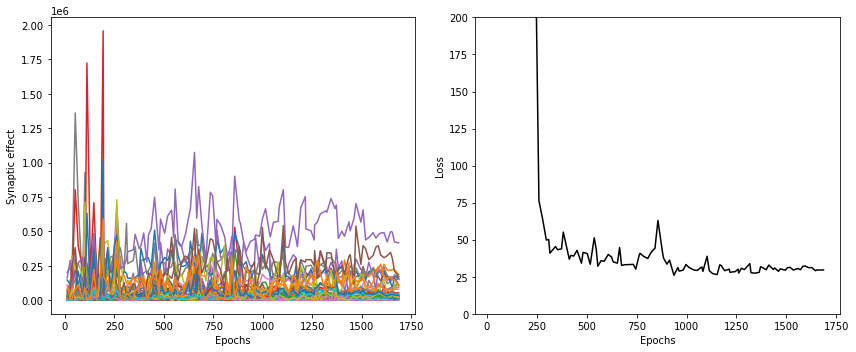

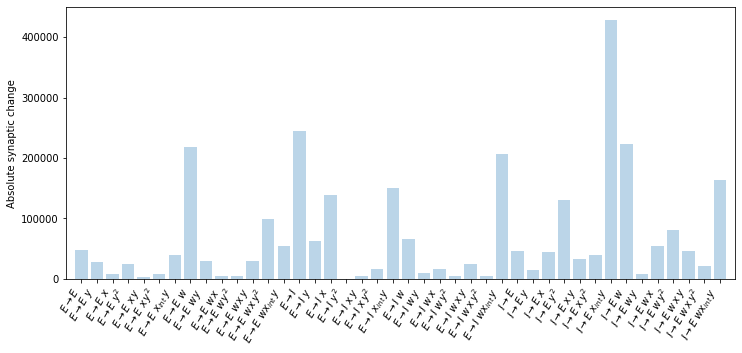

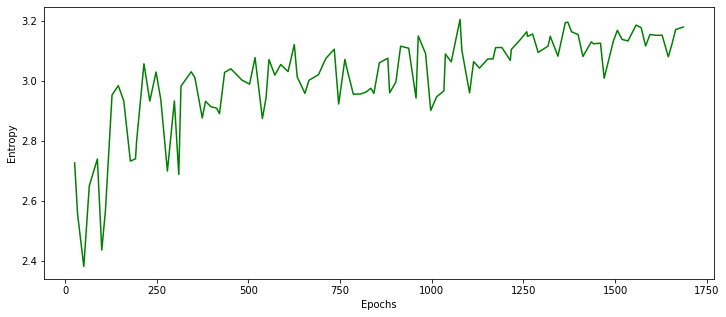

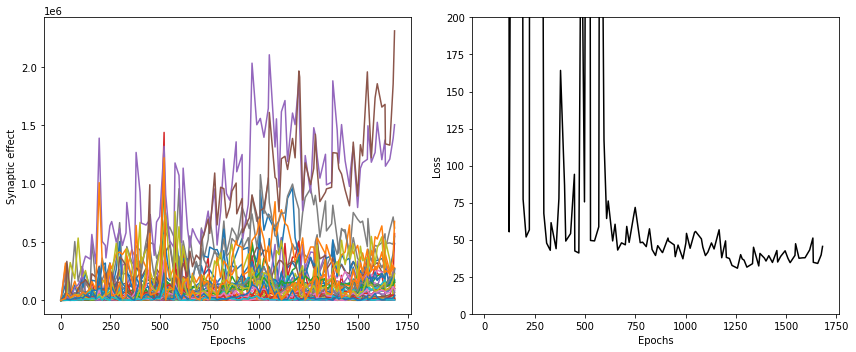

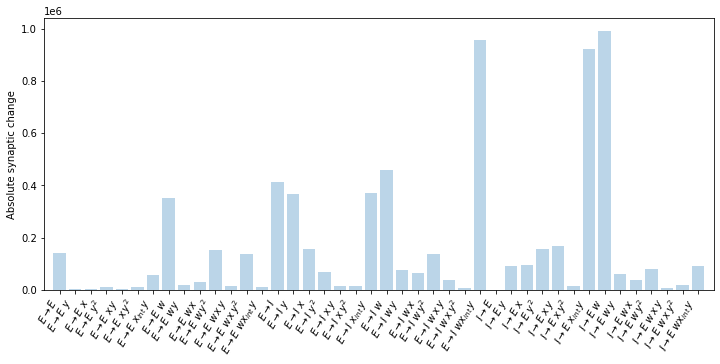

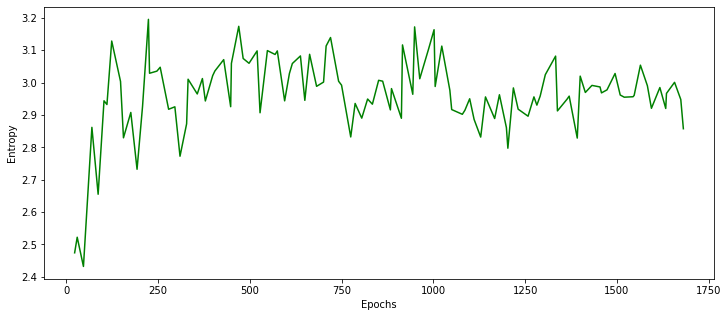

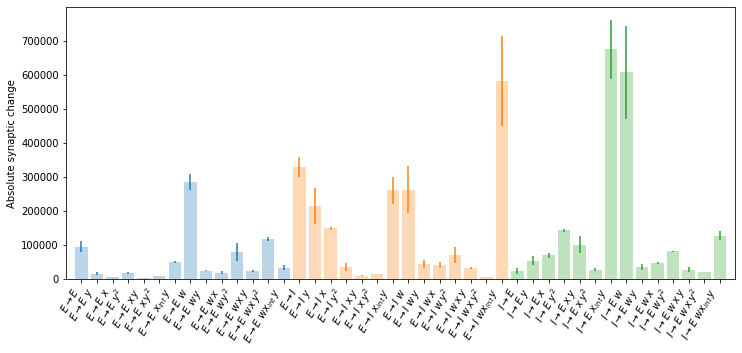

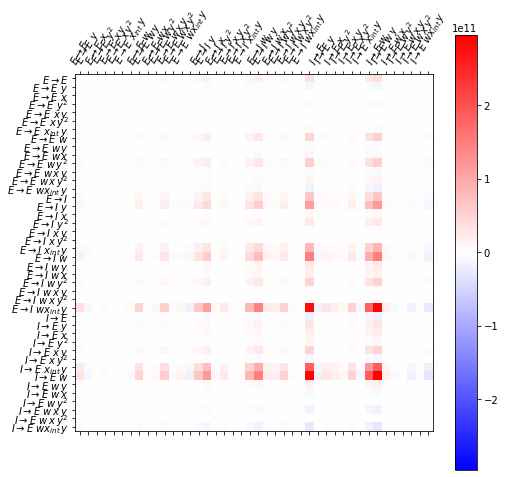

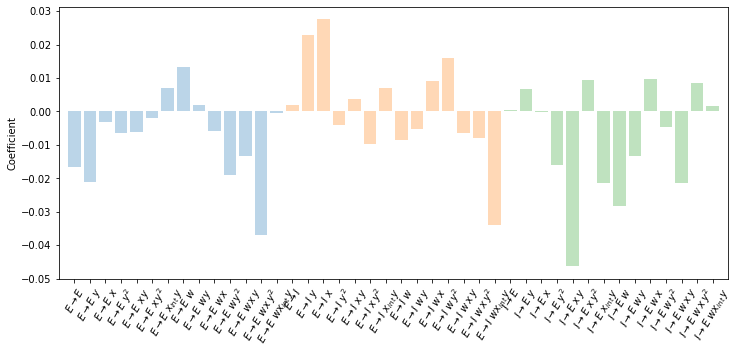

In [6]:
all_files = [
    'seq_syn_effects_tracked_batch_30_STD_EXPL_0.005_FIXED_True_L1_PENALTY_1e-07_1e-07_1e-07_2022-12-30_16:03:22.193554',
    'seq_syn_effects_tracked_batch_30_STD_EXPL_0.005_FIXED_True_L1_PENALTY_1e-07_1e-07_1e-07_2022-12-30_16:03:27.345438',
]

final_syn_effects = []
final_plasticity_coefs = []

for f in all_files:
    syn_effects_for_f, plasticity_coefs_for_f, best_loss_for_f = plot_all_2(f, 42, 30, yscale=2e6)
    final_syn_effects.append(syn_effects_for_f)
    final_plasticity_coefs.append(plasticity_coefs_for_f)
    
final_syn_effect_means = np.mean(np.stack(final_syn_effects), axis=0)
final_syn_effect_stds = np.std(np.stack(final_syn_effects), axis=0) / np.sqrt(8)

final_plasticity_coef_means = np.mean(np.stack(final_plasticity_coefs), axis=0)

# plot the synaptic effects of each plasticity rule (unsorted by size)
scale = 2
n_categories = 3
fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 2.5 * scale))
partial_rules_len = int(len(final_syn_effect_means) / n_categories)

for l in range(n_categories):
    x = np.arange(partial_rules_len) + l * partial_rules_len
    y = final_syn_effect_means[l * partial_rules_len: (l+1) * partial_rules_len]
    y_err = final_syn_effect_stds[l * partial_rules_len: (l+1) * partial_rules_len]
    axs.bar(x, y, alpha=0.3)
    axs.errorbar(x, y, yerr=y_err, ls='none')
    
axs.set_xticks(np.arange(len(final_syn_effect_means)))
axs.set_xticklabels(rule_names, rotation=60, ha='right')
axs.set_ylabel('Absolute synaptic change')
axs.set_xlim(-1, len(final_syn_effect_means))

# plot covariance of synaptic changes due to each rule
normed_syn_effect_means = final_syn_effect_means / np.sum(final_syn_effect_means)

fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))
syn_effect_cov_mat = np.cov(np.array(final_syn_effects).T)
max_abs_val = np.max(np.abs(syn_effect_cov_mat))
mappable = axs.matshow(syn_effect_cov_mat, cmap='bwr', vmin=-max_abs_val, vmax=max_abs_val)
plt.colorbar(mappable)
axs.set_xticks(np.arange(len(final_syn_effect_means)))
axs.set_xticklabels(rule_names, rotation=60)
axs.set_yticks(np.arange(len(final_syn_effect_means)))
axs.set_yticklabels(rule_names, rotation=0)

# plot the coefficients assigned to each plasticity rule (unsorted by size)
scale = 2
fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 2.5 * scale))

for l in range(n_categories):
    x = np.arange(partial_rules_len) + l * partial_rules_len
    y = final_plasticity_coef_means[l * partial_rules_len: (l+1) * partial_rules_len]
    axs.bar(x, y, alpha=0.3)
    
axs.set_xticks(np.arange(len(final_plasticity_coef_means)))
axs.set_xticklabels(rule_names, rotation=60)
axs.set_ylabel('Coefficient')
axs.set_xlim(-1, len(final_plasticity_coef_means))

# print(set_smallest_n_zero(final_syn_effect_means, 10, ))

(-1.0, 42.0)

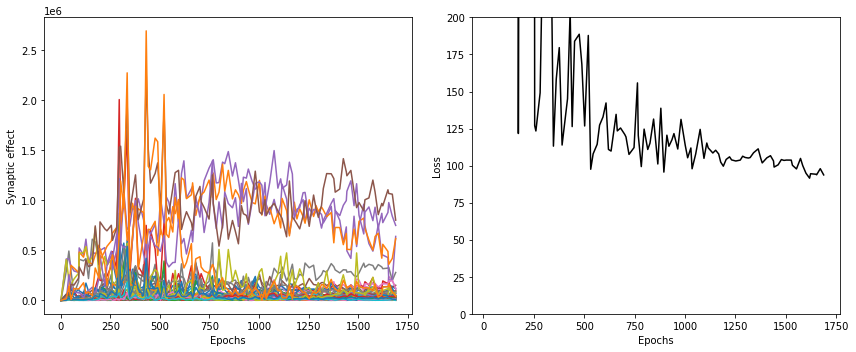

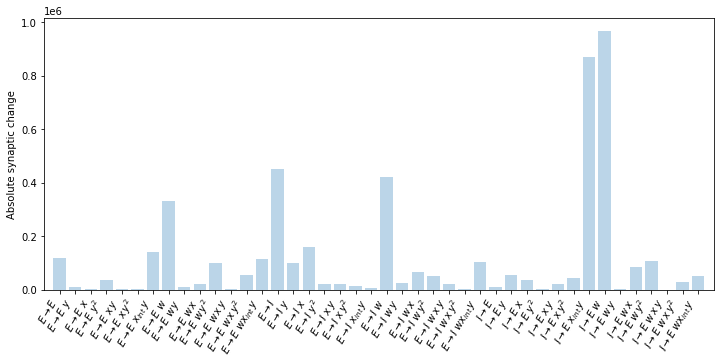

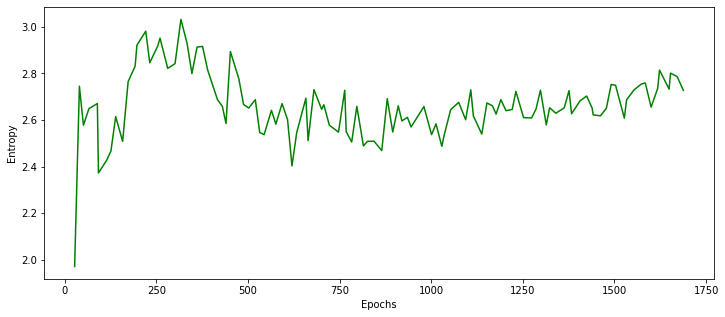

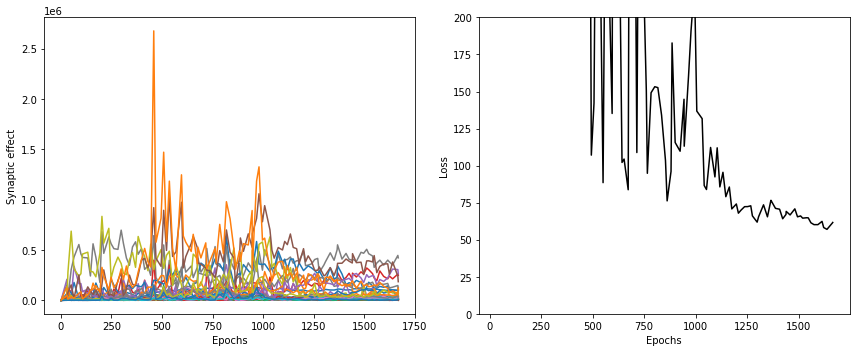

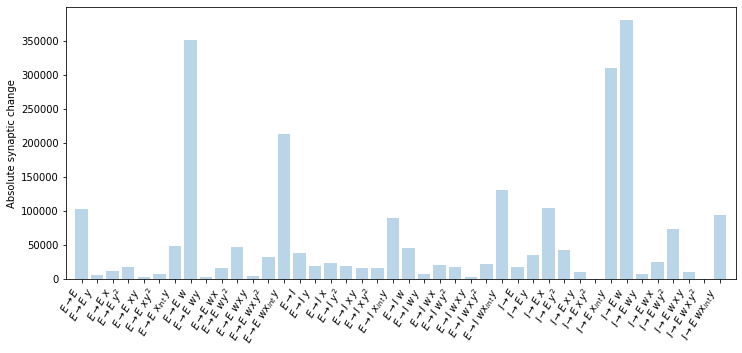

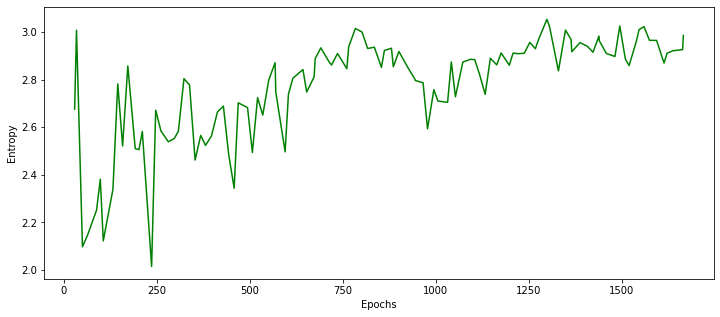

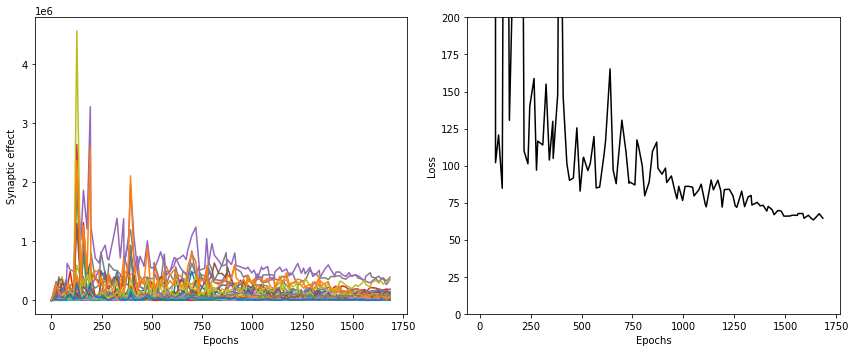

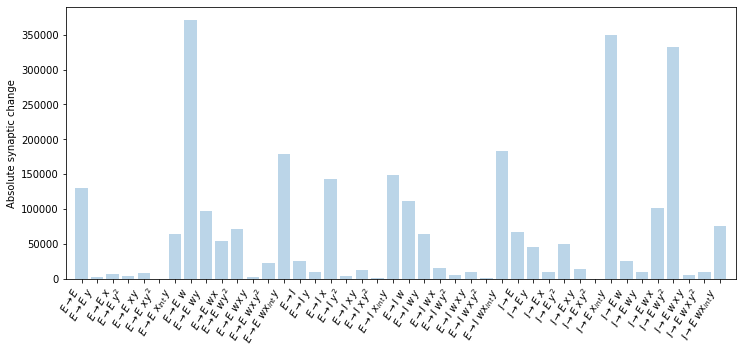

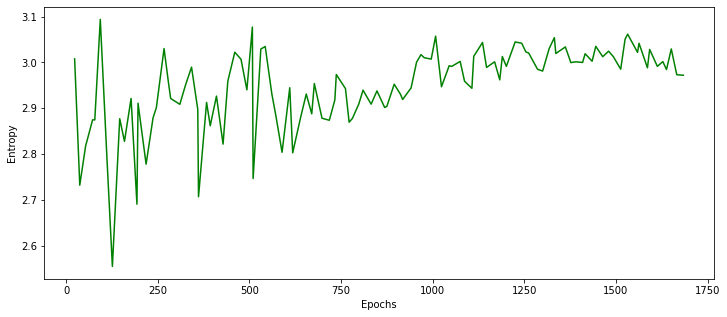

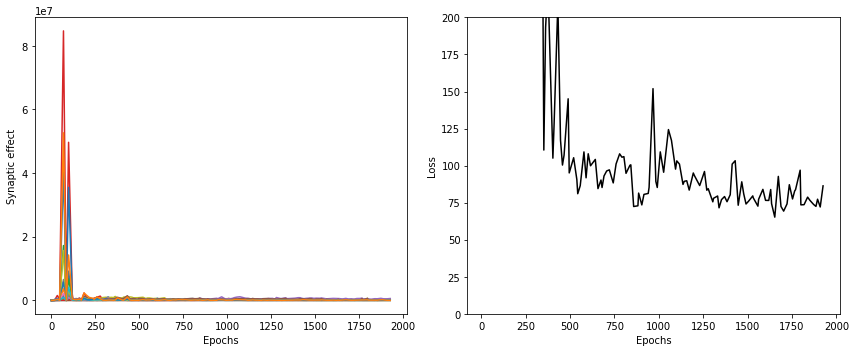

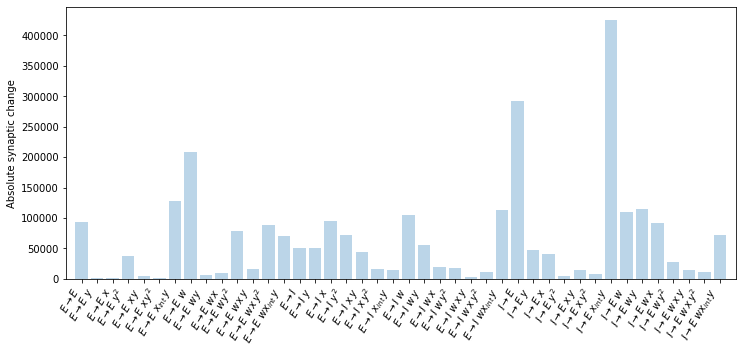

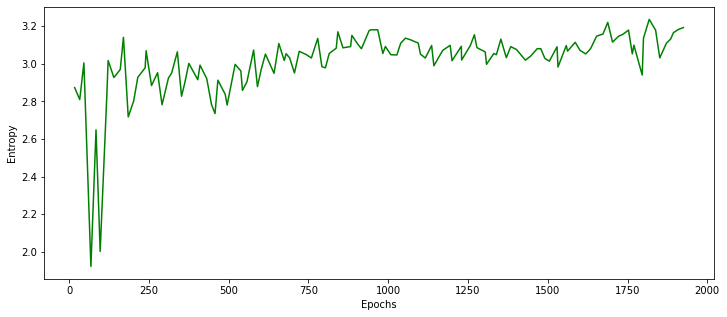

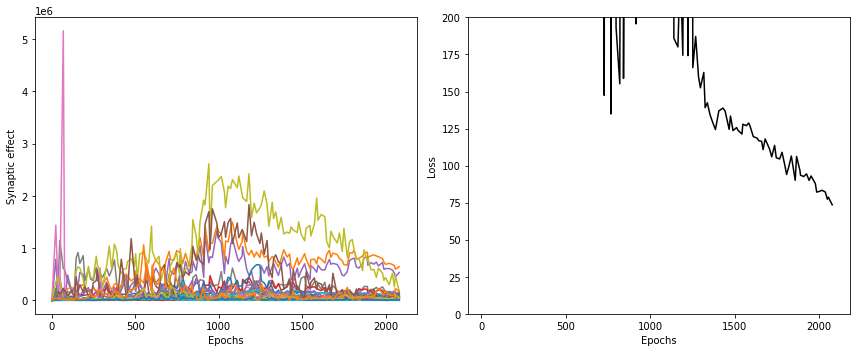

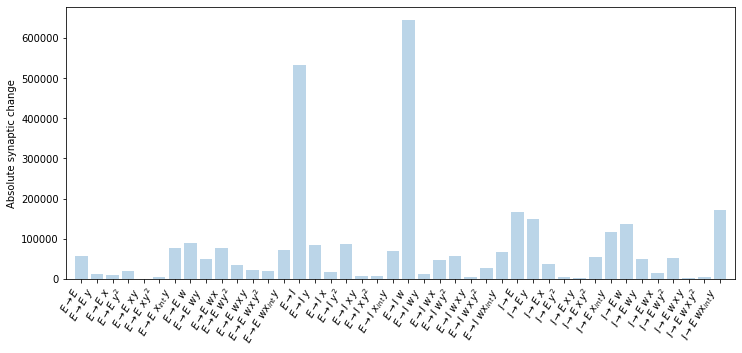

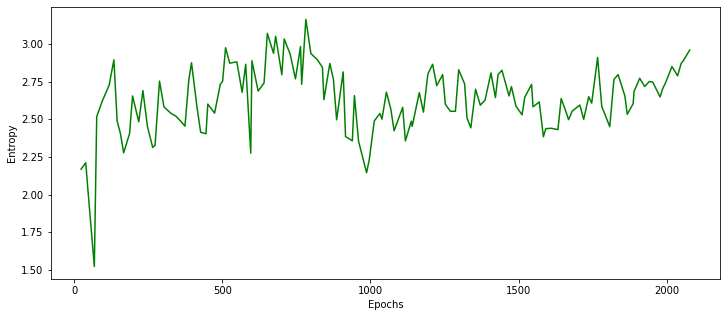

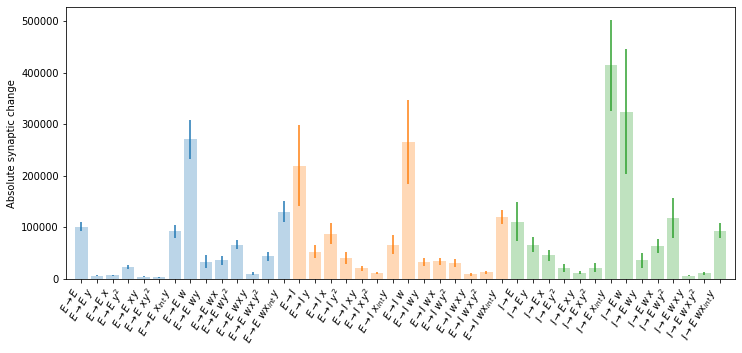

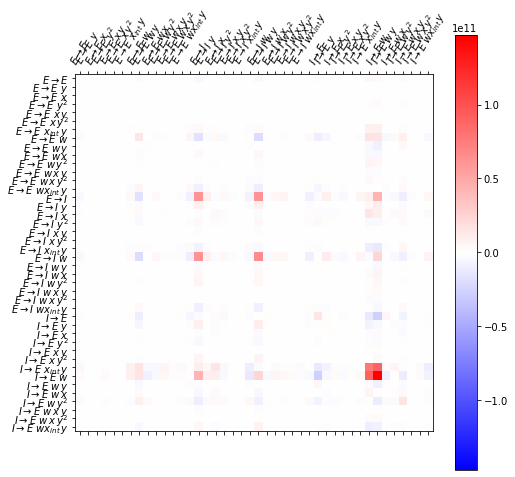

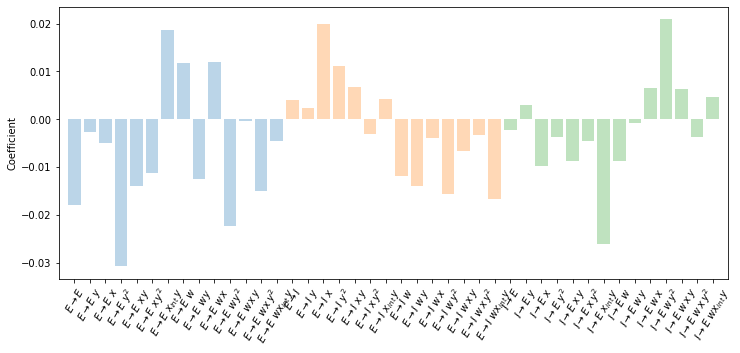

In [7]:
all_files = [
    'seq_syn_effects_tracked_batch_30_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_2022-12-30_16:03:22.193689',
    'seq_syn_effects_tracked_batch_30_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_2022-12-30_16:03:42.323179', 
    'seq_syn_effects_tracked_batch_30_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_2022-12-30_16:04:12.474681',
    'seq_syn_effects_tracked_batch_30_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_2022-12-30_16:04:29.248905', 
#     'seq_syn_effects_tracked_batch_30_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_2022-12-30_16:08:42.485978', 
#     'seq_syn_effects_tracked_batch_30_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_2022-12-31_00:08:52.873059', 
    'seq_syn_effects_tracked_batch_30_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_2022-12-31_00:09:05.635617', 
#     'seq_syn_effects_tracked_batch_30_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_2022-12-31_00:41:37.955079',
]

final_syn_effects = []
final_plasticity_coefs = []

for f in all_files:
    syn_effects_for_f, plasticity_coefs_for_f, best_loss_for_f = plot_all_2(f, 42, 30, yscale=2e6)
    final_syn_effects.append(syn_effects_for_f)
    final_plasticity_coefs.append(plasticity_coefs_for_f)
    
final_syn_effect_means = np.mean(np.stack(final_syn_effects), axis=0)
final_syn_effect_stds = np.std(np.stack(final_syn_effects), axis=0) / np.sqrt(8)

final_plasticity_coef_means = np.mean(np.stack(final_plasticity_coefs), axis=0)

# plot the synaptic effects of each plasticity rule (unsorted by size)
scale = 2
n_categories = 3
fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 2.5 * scale))
partial_rules_len = int(len(final_syn_effect_means) / n_categories)

for l in range(n_categories):
    x = np.arange(partial_rules_len) + l * partial_rules_len
    y = final_syn_effect_means[l * partial_rules_len: (l+1) * partial_rules_len]
    y_err = final_syn_effect_stds[l * partial_rules_len: (l+1) * partial_rules_len]
    axs.bar(x, y, alpha=0.3)
    axs.errorbar(x, y, yerr=y_err, ls='none')
    
axs.set_xticks(np.arange(len(final_syn_effect_means)))
axs.set_xticklabels(rule_names, rotation=60, ha='right')
axs.set_ylabel('Absolute synaptic change')
axs.set_xlim(-1, len(final_syn_effect_means))

# plot covariance of synaptic changes due to each rule
normed_syn_effect_means = final_syn_effect_means / np.sum(final_syn_effect_means)

fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))
syn_effect_cov_mat = np.cov(np.array(final_syn_effects).T)
max_abs_val = np.max(np.abs(syn_effect_cov_mat))
mappable = axs.matshow(syn_effect_cov_mat, cmap='bwr', vmin=-max_abs_val, vmax=max_abs_val)
plt.colorbar(mappable)
axs.set_xticks(np.arange(len(final_syn_effect_means)))
axs.set_xticklabels(rule_names, rotation=60)
axs.set_yticks(np.arange(len(final_syn_effect_means)))
axs.set_yticklabels(rule_names, rotation=0)

# plot the coefficients assigned to each plasticity rule (unsorted by size)
scale = 2
fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 2.5 * scale))

for l in range(n_categories):
    x = np.arange(partial_rules_len) + l * partial_rules_len
    y = final_plasticity_coef_means[l * partial_rules_len: (l+1) * partial_rules_len]
    axs.bar(x, y, alpha=0.3)
    
axs.set_xticks(np.arange(len(final_plasticity_coef_means)))
axs.set_xticklabels(rule_names, rotation=60)
axs.set_ylabel('Coefficient')
axs.set_xlim(-1, len(final_plasticity_coef_means))

# print(set_smallest_n_zero(final_syn_effect_means, 10, ))

[-2.33995094e-04 -2.77033353e-02 -1.90610918e-03 -3.77320599e-02
  1.41528513e-02 -1.47862599e-03  2.43366170e-04  1.72672313e-03
 -8.30256785e-05  3.39229640e-02 -1.60501454e-02  3.40249709e-04
 -1.07423732e-01  6.99329604e-03]


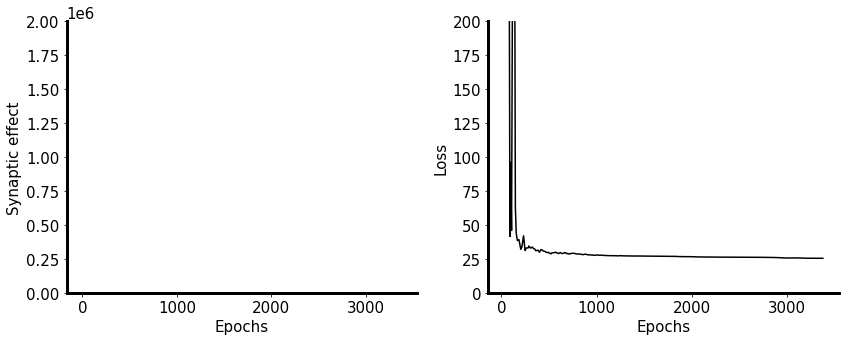

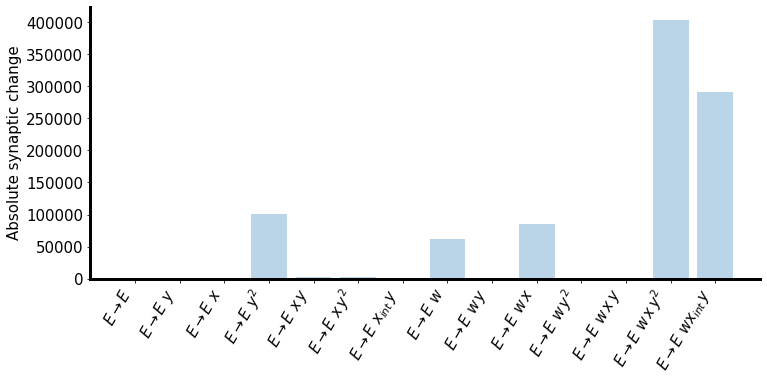

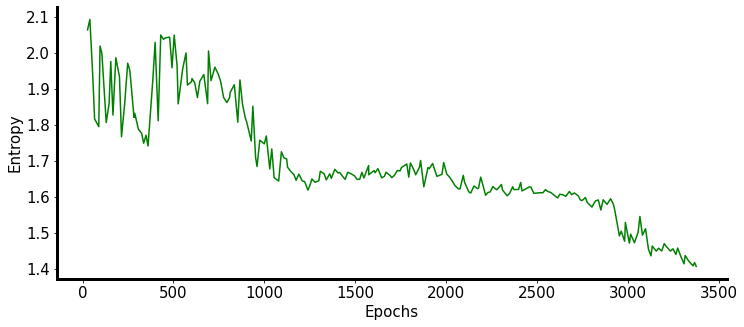

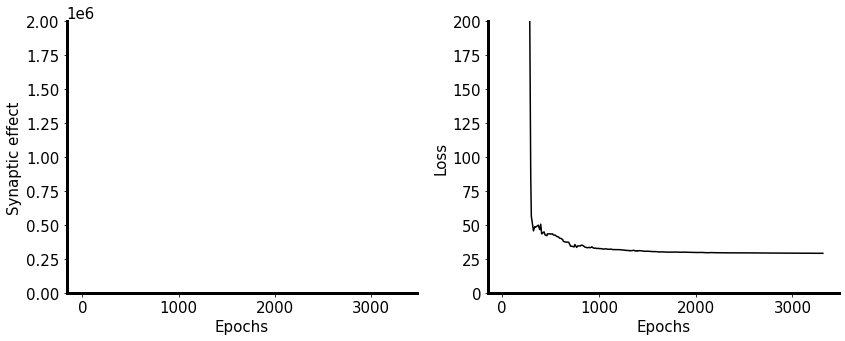

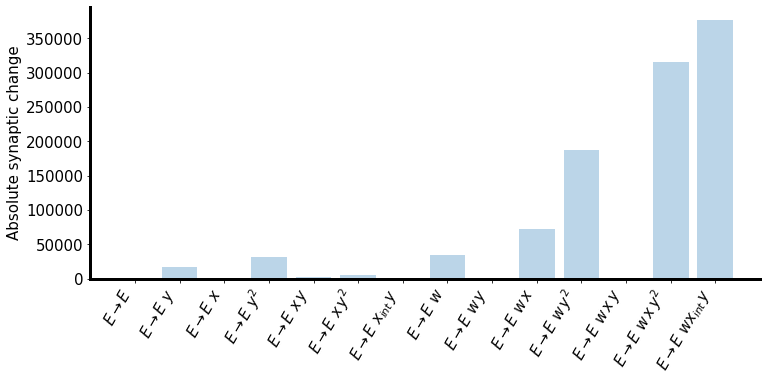

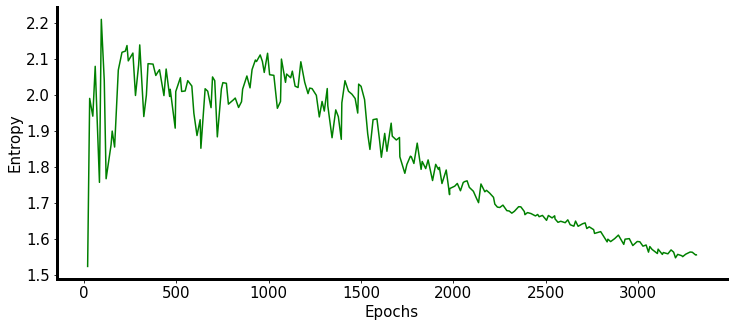

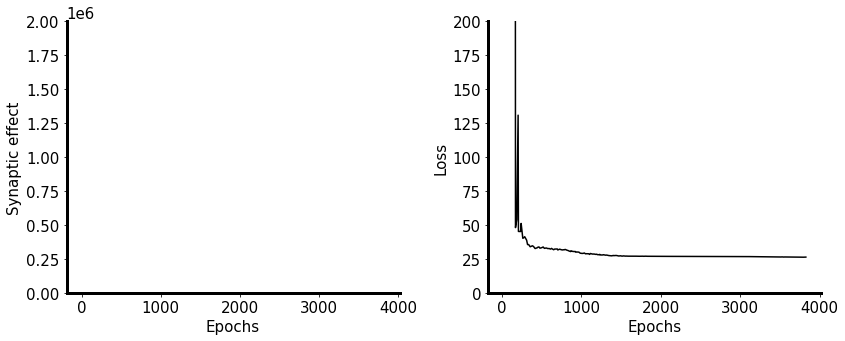

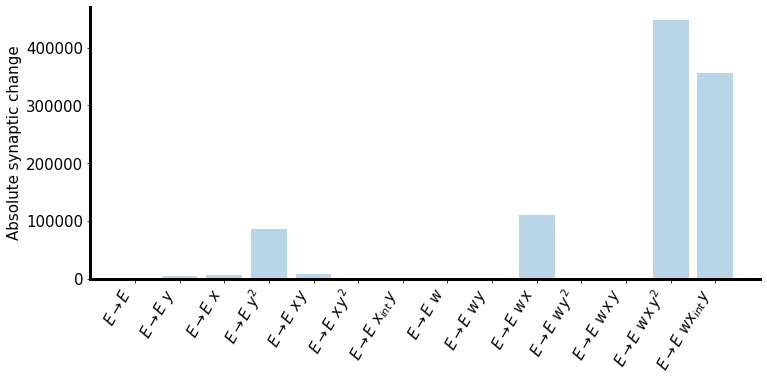

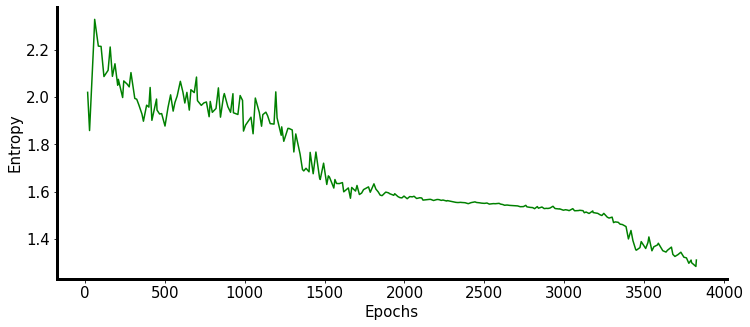

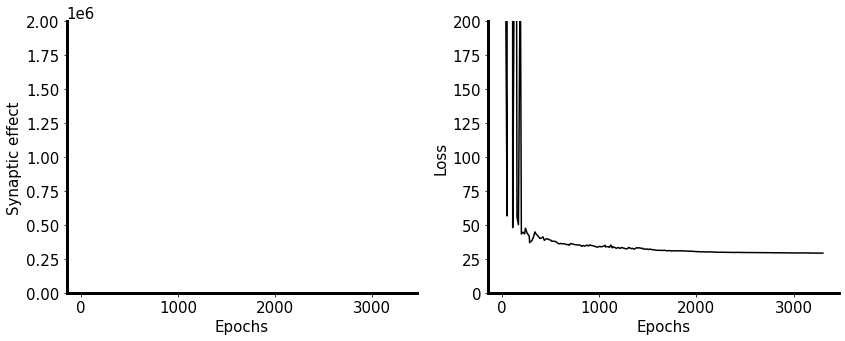

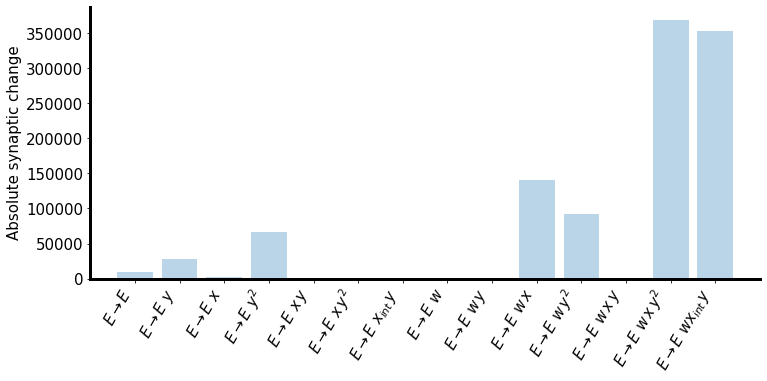

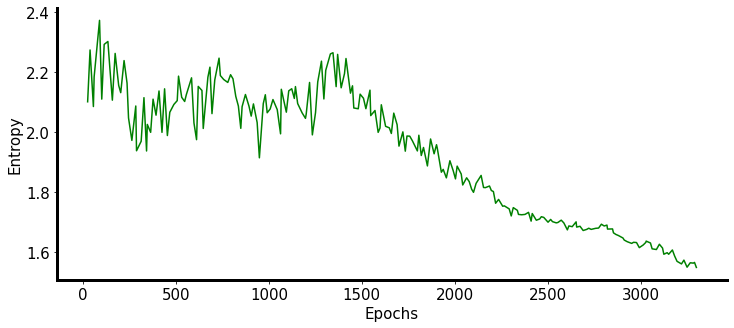

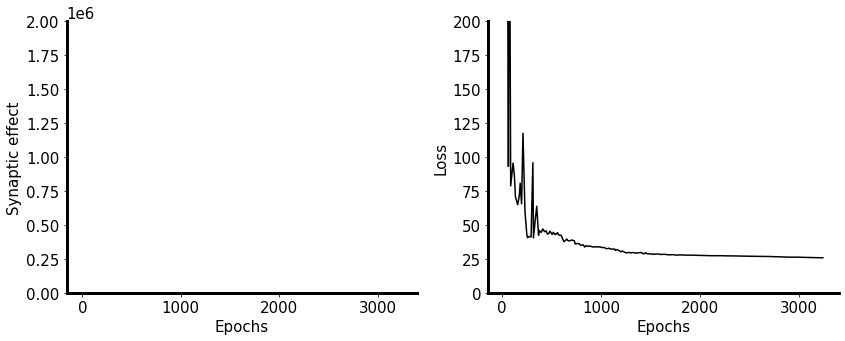

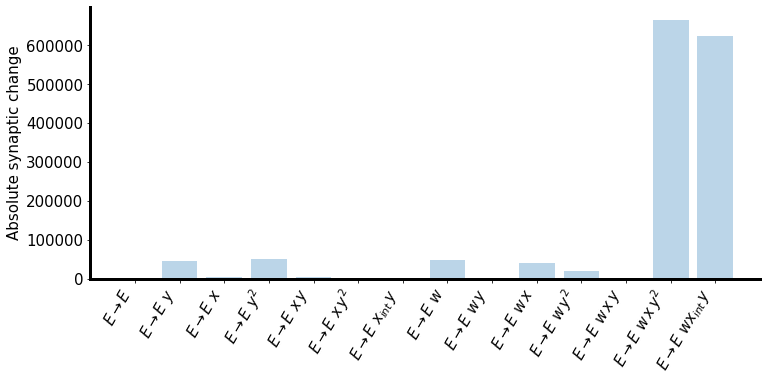

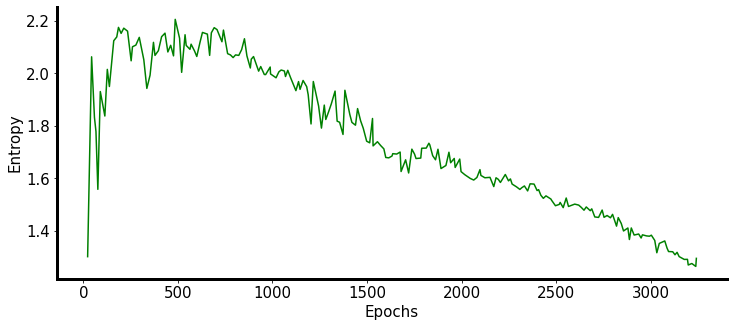

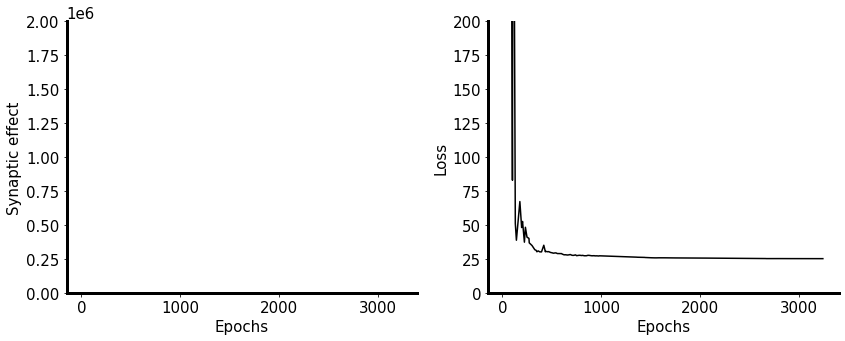

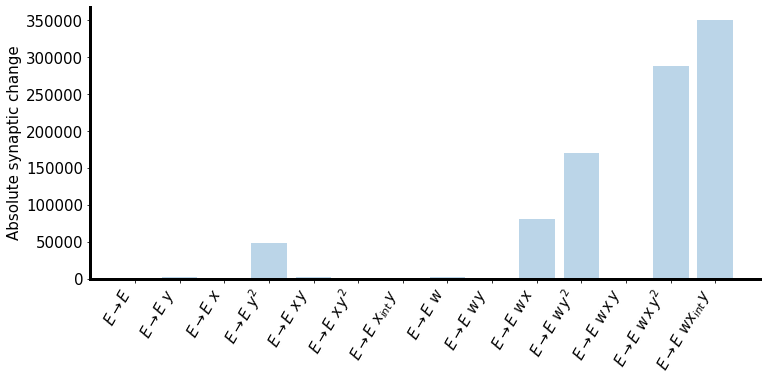

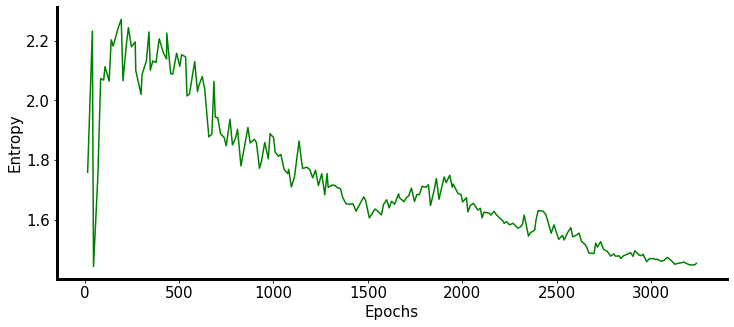

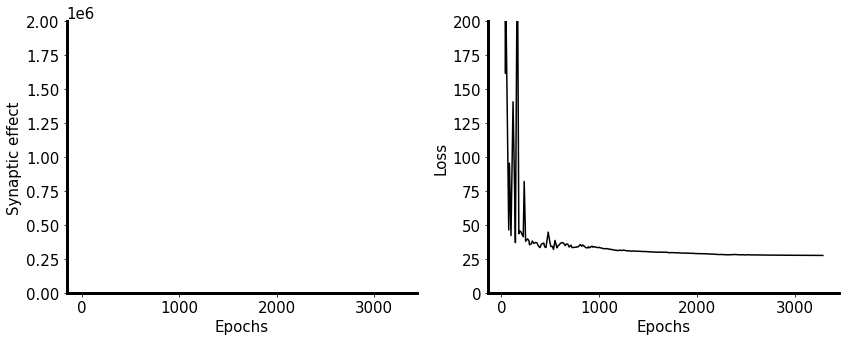

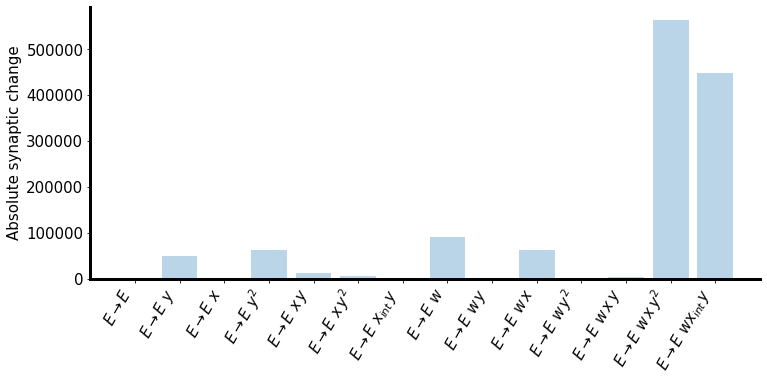

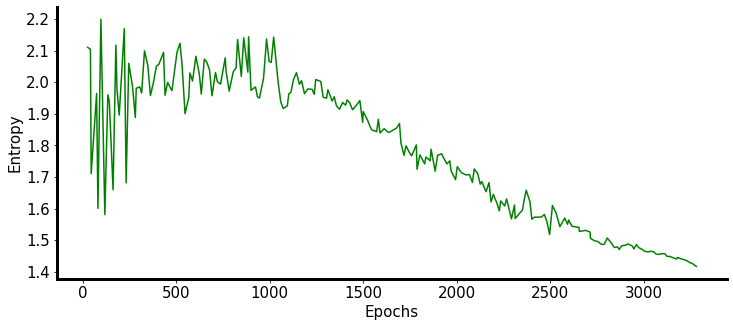

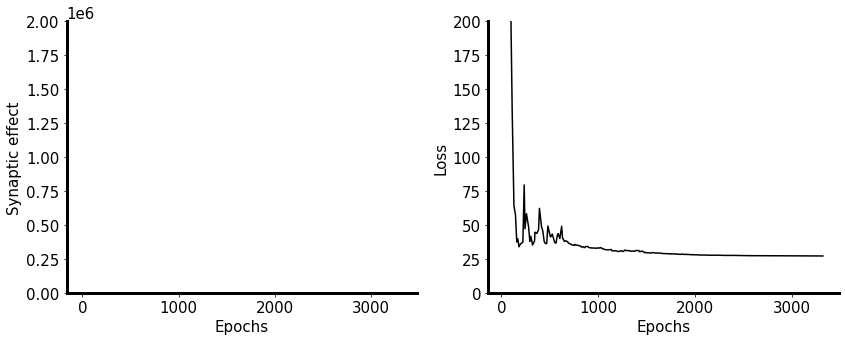

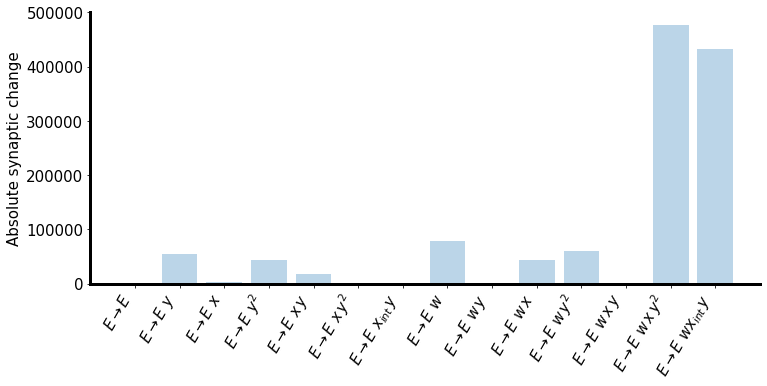

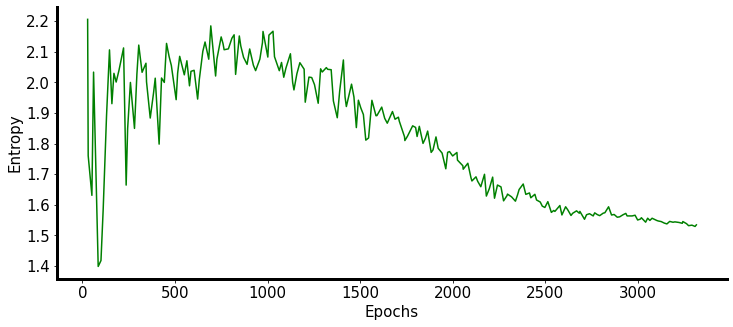

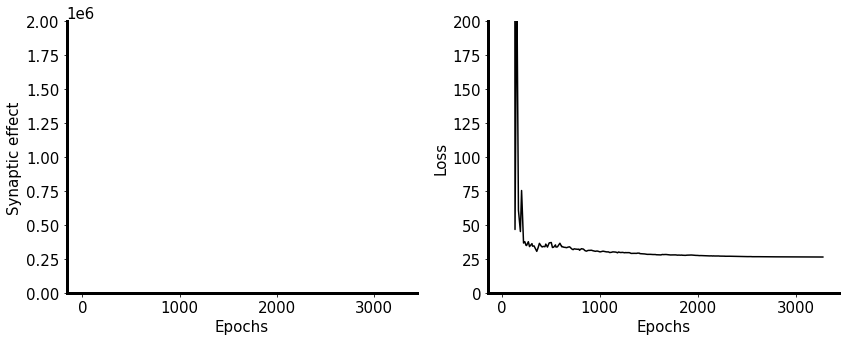

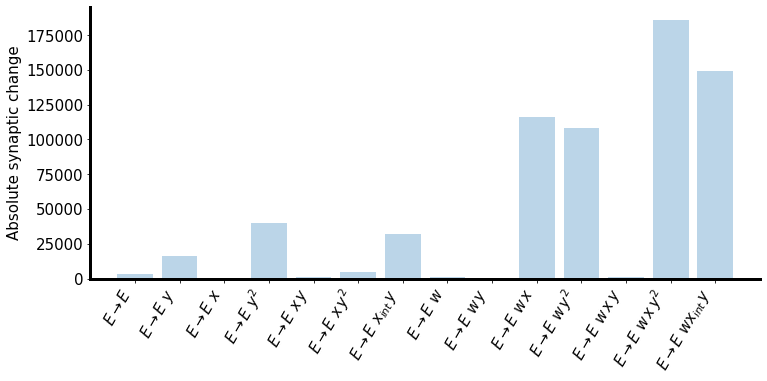

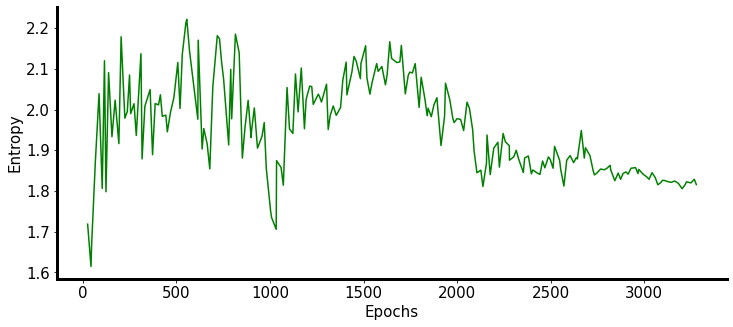

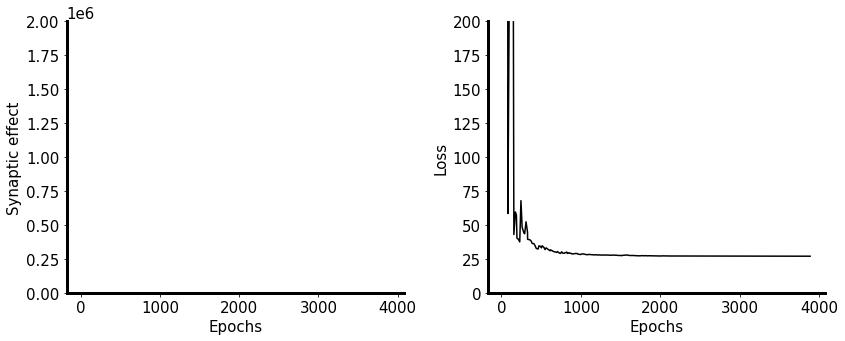

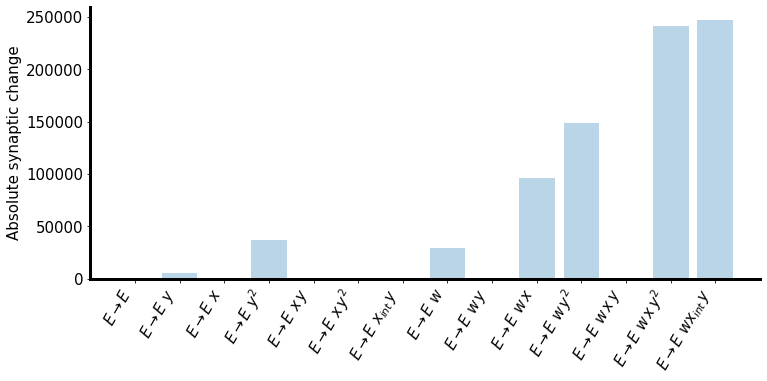

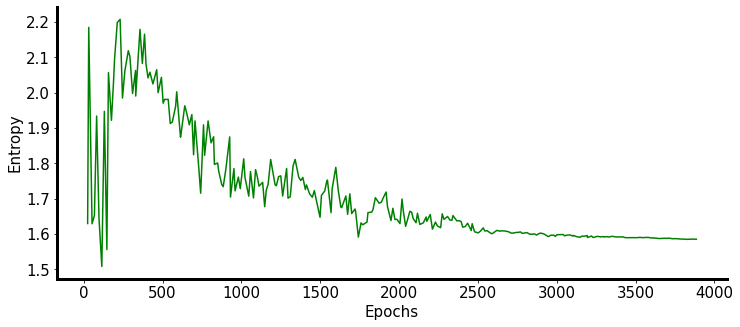

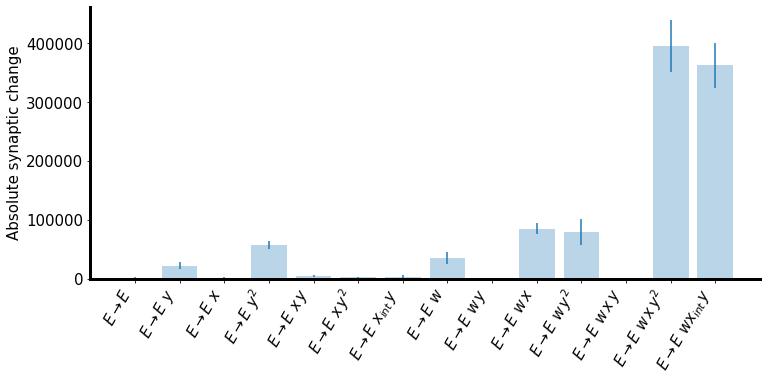

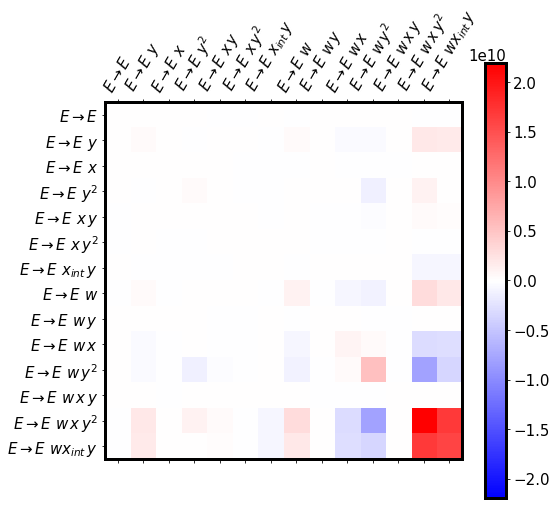

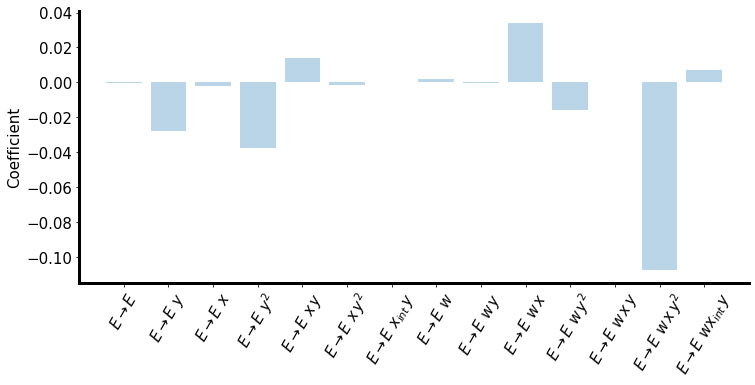

In [7]:
all_files = [
    'seq_syn_effects_tracked_batch_30_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_2022-12-28_11:51:52.518743',
    'seq_syn_effects_tracked_batch_30_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_2022-12-28_11:51:52.519243',
    'seq_syn_effects_tracked_batch_30_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_2022-12-28_11:51:53.344936',
    'seq_syn_effects_tracked_batch_30_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_2022-12-28_11:52:01.994459',
    'seq_syn_effects_tracked_batch_30_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_2022-12-28_11:52:01.994460',
    'seq_syn_effects_tracked_batch_30_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_2022-12-28_11:52:01.994481',
    'seq_syn_effects_tracked_batch_30_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_2022-12-28_11:52:56.741378',
    'seq_syn_effects_tracked_batch_30_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_2022-12-28_11:52:56.741397',
    'seq_syn_effects_tracked_batch_30_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_2022-12-28_11:52:57.660707',
    'seq_syn_effects_tracked_batch_30_STD_EXPL_0.005_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_2022-12-28_11:54:15.319681',
]

final_syn_effects = []
final_plasticity_coefs = []

for f in all_files:
    syn_effects_for_f, plasticity_coefs_for_f, best_loss_for_f = plot_all_2(f, 14, 30, n_categories=1, yscale=2e6)
    final_syn_effects.append(syn_effects_for_f)
    final_plasticity_coefs.append(plasticity_coefs_for_f)
    
final_syn_effect_means = np.mean(np.stack(final_syn_effects), axis=0)
final_syn_effect_stds = np.std(np.stack(final_syn_effects), axis=0) / np.sqrt(10)

final_plasticity_coef_means = np.mean(np.stack(final_plasticity_coefs), axis=0)

# plot the synaptic effects of each plasticity rule (unsorted by size)
scale = 2
n_categories = 1
fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 2.5 * scale))
format_axs(axs)
partial_rules_len = int(len(final_syn_effect_means) / n_categories)

for l in range(n_categories):
    x = np.arange(partial_rules_len) + l * partial_rules_len
    y = final_syn_effect_means[l * partial_rules_len: (l+1) * partial_rules_len]
    y_err = final_syn_effect_stds[l * partial_rules_len: (l+1) * partial_rules_len]
    axs.bar(x, y, alpha=0.3)
    axs.errorbar(x, y, yerr=y_err, ls='none')
    
axs.set_xticks(np.arange(len(final_syn_effect_means)))
axs.set_xticklabels(rule_names, rotation=60, ha='right')
axs.set_ylabel('Absolute synaptic change')
axs.set_xlim(-1, len(final_syn_effect_means))

# plot covariance of synaptic changes due to each rule
normed_syn_effect_means = final_syn_effect_means / np.sum(final_syn_effect_means)

fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))
syn_effect_cov_mat = np.cov(np.array(final_syn_effects).T)
max_abs_val = np.max(np.abs(syn_effect_cov_mat))
mappable = axs.matshow(syn_effect_cov_mat, cmap='bwr', vmin=-max_abs_val, vmax=max_abs_val)
plt.colorbar(mappable)
axs.set_xticks(np.arange(len(final_syn_effect_means)))
axs.set_xticklabels(rule_names, rotation=60)
axs.set_yticks(np.arange(len(final_syn_effect_means)))
axs.set_yticklabels(rule_names, rotation=0)

# plot the coefficients assigned to each plasticity rule (unsorted by size)
scale = 2
n_categories = 1
fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 2.5 * scale))
format_axs(axs)

for l in range(n_categories):
    x = np.arange(partial_rules_len) + l * partial_rules_len
    y = final_plasticity_coef_means[l * partial_rules_len: (l+1) * partial_rules_len]
    axs.bar(x, y, alpha=0.3)
    
axs.set_xticks(np.arange(len(final_plasticity_coef_means)))
axs.set_xticklabels(rule_names, rotation=60)
axs.set_ylabel('Coefficient')
axs.set_xlim(-1, len(final_plasticity_coef_means))

print(final_plasticity_coef_means)
